<a href="https://colab.research.google.com/github/benjamin-mallefait/AN2DL-2024-2025---Homework-2/blob/main/FINAL_TRY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025]AN2DL/Homework2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025]AN2DL/Homework2


## ⚙️ Import Libraries

In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import tensorflow.keras as tfk

import matplotlib.pyplot as plt
%matplotlib inline

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


In [ ]:
%%capture
pip install -U albumentations

## ⏳ Load the Data

In [ ]:
data = np.load("mars_for_students_cleaned.npz")

print("Keys in the data dictionary:")
print(data.files)
training_set = data["training_set"]
X_train = training_set[:, 0, :, :]
y_train = training_set[:, 1, :, :]


X_test = data["test_set"]

print(f"training set shape: {data['training_set'].shape}")
print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Keys in the data dictionary:
['training_set', 'test_set']
training set shape: (2505, 2, 64, 128)
Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


In [ ]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 0.01

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 500

# Set data split size for training and validation
SPLITS_SIZE = 300

NUM_CLASSES = 5

class_labels = {
	0: "Background",
	1: "Soil",
	2: "Bedrock",
	3: "Sand",
	4: "Big Rock"
}

In [ ]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:
y_train = y_train[..., np.newaxis]

print(y_train.shape)

(2505, 64, 128, 1)


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random

def display_image_and_mask(image, mask):
  """Displays an image and its corresponding mask side-by-side.

  Args:
    image: The input image as a NumPy array.
    mask: The corresponding mask as a NumPy array.
  """

  plt.figure(figsize=(10, 5))

  plt.subplot(121)
  plt.imshow(image, cmap="gray")
  plt.title("Input image")

  plt.subplot(122)
  plt.imshow(mask, cmap=ListedColormap(["black", "yellow", "green", "blue", "grey"]))
  plt.title("Target image")



def display_random_images_and_masks(images, masks, num_images=5):
  """Displays a specified number of random images and their masks.

  Args:
    images: The input images as a NumPy array.
    masks: The corresponding masks as a NumPy array.
    num_images: The number of images to display (default is 5).
  """

  # Generate random indices for image selection
  random_indices = random.sample(range(len(images)), num_images)

  # Display images and masks for selected indices
  for index in random_indices:
    image = images[index]
    mask = masks[index]

    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    plt.imshow(image, cmap="gray")
    plt.title("Input image")

    plt.subplot(122)
    plt.imshow(mask, cmap=ListedColormap(["black", "yellow", "green", "blue", "grey"]))
    plt.title("Target image")

    plt.show()

In [ ]:
# separate in train val test
from sklearn.model_selection import train_test_split

train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
    X_train, y_train, test_size=SPLITS_SIZE, random_state=SEED
)
train_img, val_img, train_lbl, val_lbl = train_test_split(
    train_val_img, train_val_lbl, test_size=SPLITS_SIZE, random_state=SEED
)

print(f"Train set shape: {train_img.shape}")
print(f"Validation set shape: {val_img.shape}")
print(f"Test set shape: {test_img.shape}")

Train set shape: (1905, 64, 128, 1)
Validation set shape: (300, 64, 128, 1)
Test set shape: (300, 64, 128, 1)


In [ ]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    print(image.shape)
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [ ]:
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations import HorizontalFlip, VerticalFlip, RandomRotate90
from albumentations import ShiftScaleRotate

def apply_albumentations(image, mask, augmentations):
    """
    Apply albumentations augmentations to the given image and mask.
    """
    # Convert TensorFlow tensors to numpy arrays
    image = image.numpy()
    mask = mask.numpy()

    # Apply the augmentations
    augmented = augmentations(image=image, mask=mask)
    augmented_image = augmented["image"]
    augmented_mask = augmented["mask"]

    return augmented_image.astype(np.float32), augmented_mask.astype(np.float32)

def wrap_albumentations(image, mask, augmentations=None):
    """
    Wrapper to call apply_albumentations using tf.py_function.
    """
    print(f"WRAP_IMAGe {image.shape}")
    print(f"mask_IMAGe {mask.shape}")

    image, mask = tf.py_function(
        func=lambda img, msk: apply_albumentations(img, msk, augmentations),
        inp=[image, mask],
        Tout=[tf.float32, tf.float32]
    )

    image.set_shape((64, 128, 1))
    mask.set_shape((64, 128, 1))

    return image, mask

def set_shapes(img, label, img_shape=(64,128,1)):
    img.set_shape(img_shape)
    label.set_shape(img_shape)
    return img, label




In [ ]:
from functools import partial

def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    print(label)
    keys_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply category mapping
    # dataset = dataset.map(
    #     lambda x, y: (x, apply_category_mapping(y)),
    #     num_parallel_calls=tf.data.AUTOTUNE
    # )

    if augment:

        augmentations = A.Compose([
            #A.RandomRotate90(),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.Flip(),
            # A.Transpose(),
            #A.GaussNoise(),
            A.OneOf([
                A.MotionBlur(p=.2),
                #A.MedianBlur(blur_limit=3, p=0.1),
                A.Blur(blur_limit=3, p=0.1),
            ], p=0.2),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
            A.OneOf([
                A.OpticalDistortion(p=0.3),
                A.GridDistortion(p=.1),
            ], p=0.2),
            A.RandomGridShuffle(grid = (3,3), always_apply=False, p = 0.3),
            A.RandomBrightnessContrast(brightness_limit = 0.2,
                                        contrast_limit = 0.2,
                                        always_apply = False,
                                        p = 0.2
                                      ),
            #A.Sharpen(alpha=(0.2, 0.5), lightness = (0.5, 1.0), always_apply=False, p = 0.5),
            A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
            # A.RandomCrop(height=64, width=128, p=1),
            # A.OneOf([
            #     #A.CLAHE(clip_limit=2),
            #     A.RandomBrightnessContrast(),
            # ], p=0.3),
            # A.HueSaturationValue(p=0.3),
        ])


        # Apply Albumentations augmentations
        dataset = dataset.map(
            partial(wrap_albumentations, augmentations=augmentations),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset.map(
        set_shapes,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

Creating datasets...


<ipython-input-12-62be4001c797>:58: UserWarning: Argument 'num_holes' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-12-62be4001c797>:58: UserWarning: Argument 'max_h_size' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-12-62be4001c797>:58: UserWarning: Argument 'max_w_size' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-12-62be4001c797>:58: UserWarning: Argument 'fill_value' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-12-62be4001c797>:58: UserWarning: Argument 'mask_fill_value' is no

WRAP_IMAGe (64, 128, 1)
mask_IMAGe (64, 128, 1)
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'float32'>


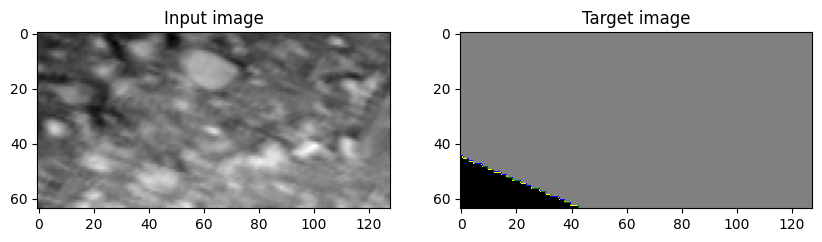

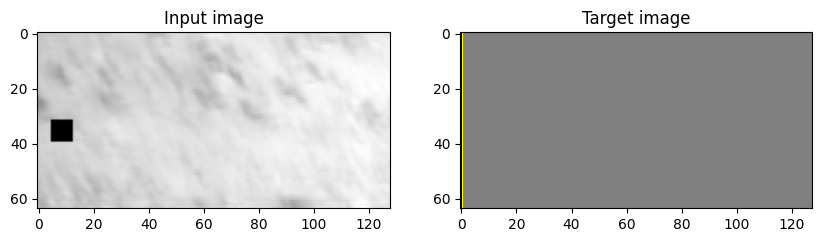

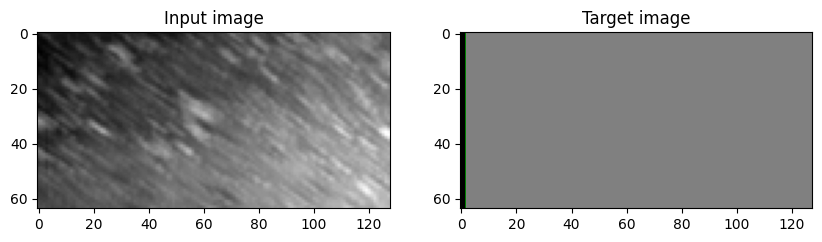

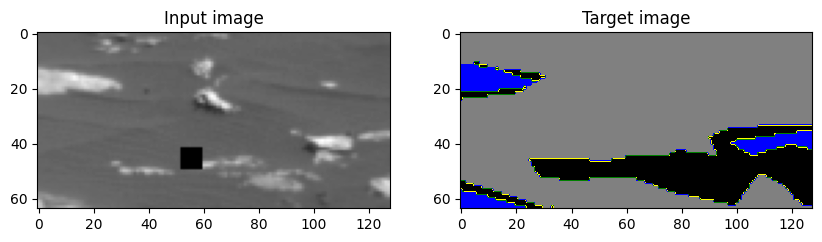

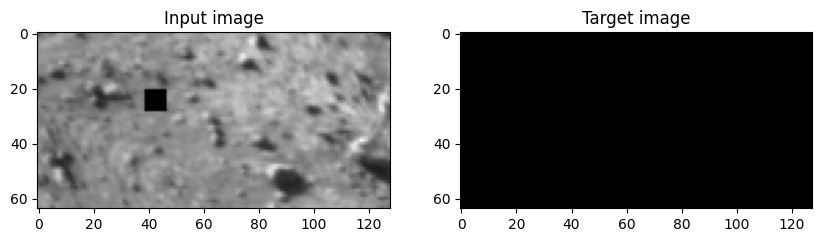

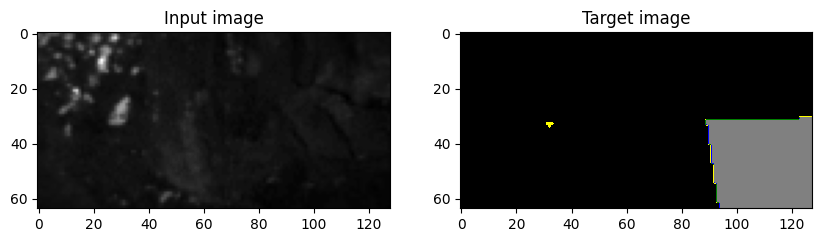

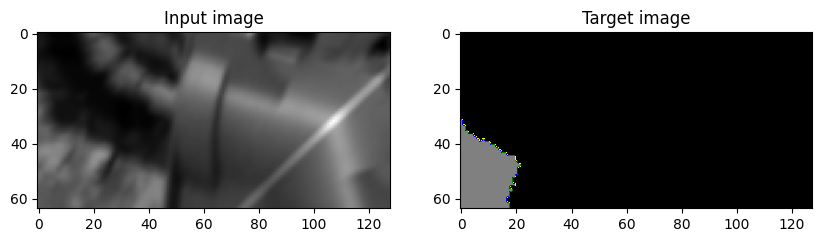

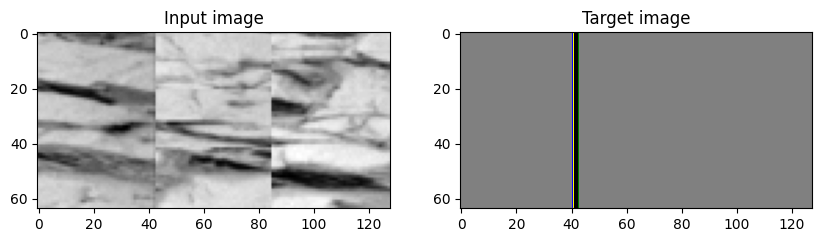

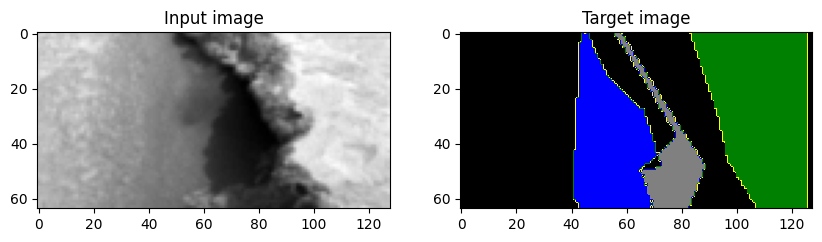

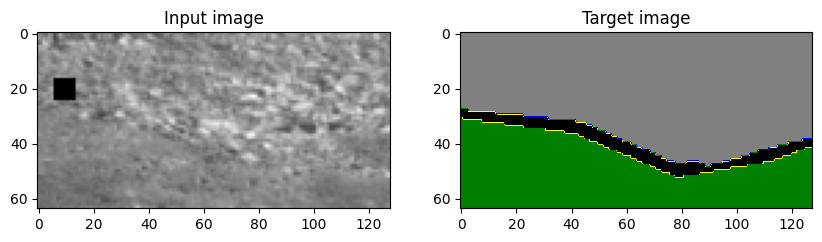

In [ ]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=SEED
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    test_img, test_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    display_random_images_and_masks(images, labels, num_images=10)
    break

## 🛠️ Train and Save the Model

In [ ]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation("relu")(conv)

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation("relu")(conv)

    if dropout > 0:
        conv = tfkl.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return tfkl.Lambda(lambda x, repnum: tfk.backend.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).

    1. conv - BN - Activation - conv - BN - Activation
                                          - shortcut  - BN - shortcut+BN

    2. conv - BN - Activation - conv - BN
                                     - shortcut  - BN - shortcut+BN - Activation

    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation('relu')(conv)

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = tfkl.Dropout(dropout)(conv)

    shortcut = tfkl.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = tfkl.BatchNormalization(axis=3)(shortcut)

    res_path = tfkl.add([shortcut, conv])
    res_path = tfkl.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = tfkl.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = tfk.backend.int_shape(x)
    shape_g = tfk.backend.int_shape(gating)

    # Getting the x signal to the same shape as the gating signal
    theta_x = tfkl.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = tfk.backend.int_shape(theta_x)

    # Getting the gating signal to the same number of filters as the inter_shape
    phi_g = tfkl.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = tfkl.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = tfkl.add([upsample_g, theta_x])
    act_xg = tfkl.Activation('relu')(concat_xg)
    psi = tfkl.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = tfkl.Activation('sigmoid')(psi)
    shape_sigmoid = tfk.backend.int_shape(sigmoid_xg)
    upsample_psi = tfkl.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = tfkl.multiply([upsample_psi, x])

    result = tfkl.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = tfkl.BatchNormalization()(result)
    return result_bn


In [ ]:
def Attention_ResUNet(input_shape=(64, 128, 1), NUM_CLASSES=NUM_CLASSES, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention

    '''
    # network structure
    FILTER_NUM = 32 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = tfkl.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = tfkl.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = tfkl.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = tfkl.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = tfkl.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = tfkl.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = tfkl.BatchNormalization(axis=axis)(conv_final)
    conv_final = tfkl.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = tfk.models.Model(inputs, conv_final, name="AttentionResUNet")
    return model


Model: "AttentionResUNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization    │ (None, 64, 128, 32)  │          128 │ conv2d[0][0]        │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation             │ (None, 64, 128, 32)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_2 (Conv2D)      │ (None, 64, 128, 32)  │           64 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)      │ (None, 64, 128, 32)  │        9,248 │ activation[0][0]    │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_2  │ (None, 64, 128, 32)  │          128 │ conv2d_2[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1  │ (None, 64, 128, 32)  │          128 │ conv2d_1[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ add (Add)              │ (None, 64, 128, 32)  │            0 │ batch_normalizatio… │    -    │
│                        │                      │              │ batch_normalizatio… │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_1           │ (None, 64, 128, 32)  │            0 │ add[0][0]           │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 32)   │            0 │ activation_1[0][0]  │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_3 (Conv2D)      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d[0][0] │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_3  │ (None, 32, 64, 64)   │          256 │ conv2d_3[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_2           │ (None, 32, 64, 64)   │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_5 (Conv2D)    

 Total params: 9,787,005 (37.33 MB)

 Trainable params: 9,776,243 (37.29 MB)

 Non-trainable params: 10,762 (42.04 KB)

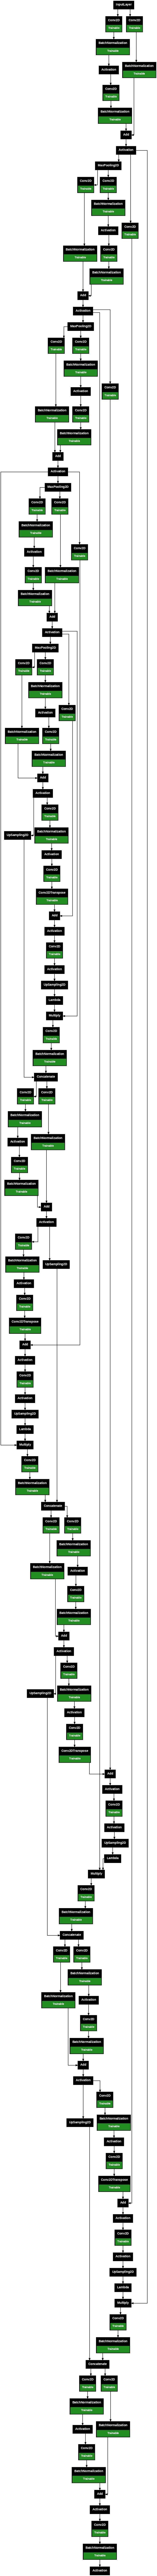

In [ ]:
model = Attention_ResUNet()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)


In [ ]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def load_single_image(image_ind, label, input_size=( 64, 128)):

    image = X_train[image_ind]
    label = y_train[image_ind]

    return image, label


In [ ]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image_path = image
        self.label_path = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = label #apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [ ]:
# Compile the model
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Paramètres de base
initial_learning_rate = 0.1
final_learning_rate = 0.0001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/EPOCHS)
steps_per_epoch = int(X_train.shape[0]/BATCH_SIZE)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=steps_per_epoch,
    decay_rate=learning_rate_decay_factor,
    staircase=True)
# Création de l'optimiseur avec ce scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipvalue=1.0)

print("Compiling model...")
model.compile(
    #loss=tf.keras.losses.CategoricalFocalCrossentropy(
    #    alpha=tf.constant(list(inverse_frequency.values()), dtype=tf.float32),
    #    gamma=2.0,
    #    label_smoothing = 0.1,
    #    from_logits=True,
    #    reduction = 'sum_over_batch_size',  # Common reduction method for multi-class classification
    #    axis = -1  # Typically, crossentropy is computed along the last axis
    #),
    #loss=tf.keras.losses.CategoricalFocalCrossentropy(gamma=2.0, from_logits=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, ignore_class=0),
    #loss=combined_loss,
    #loss=FocalTverskyLoss,
    # loss = tfk.losses.Tversky(
    #   alpha=0.5, beta=0.5, reduction="sum_over_batch_size", name="tversky", dtype=None
    # ),
    optimizer=tf.keras.optimizers.AdamW(lr_schedule),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=50,
    restore_best_weights=True
)

viz_callback = VizCallback(0, 0)

reduceOnPlateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_mean_iou",
    factor=0.1,
    patience=40
)

Epoch 1/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2862 - loss: 1.4859 - mean_iou: 0.1363   

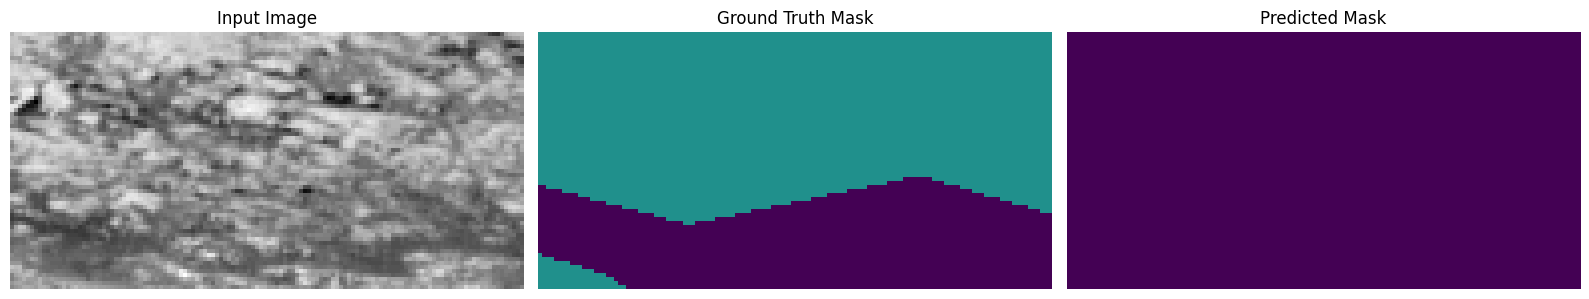

30/30 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.2872 - loss: 1.4831 - mean_iou: 0.1372 - val_accuracy: 0.2445 - val_loss: 1.9094 - val_mean_iou: 0.0000e+00
Epoch 2/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 64s 360ms/step - accuracy: 0.3648 - loss: 1.2734 - mean_iou: 0.1976 - val_accuracy: 0.2445 - val_loss: 2.0719 - val_mean_iou: 0.0000e+00
Epoch 3/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 357ms/step - accuracy: 0.3944 - loss: 1.2351 - mean_iou: 0.2235 - val_accuracy: 0.2445 - val_loss: 1.6201 - val_mean_iou: 0.0000e+00
Epoch 4/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.4017 - loss: 1.2135 - mean_iou: 0.2254 - val_accuracy: 0.2445 - val_loss: 1.6183 - val_mean_iou: 0.0000e+00
Epoch 5/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 363ms/step - accuracy: 0.3959 - loss: 1.2172 - mean_iou: 0.2271 - val_accuracy: 0.2445 - val_loss: 2.0757 - val_mean_iou: 6.3063e-06
Epoch 6/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.3891 - loss: 1.2035 - mean_iou: 0.2246

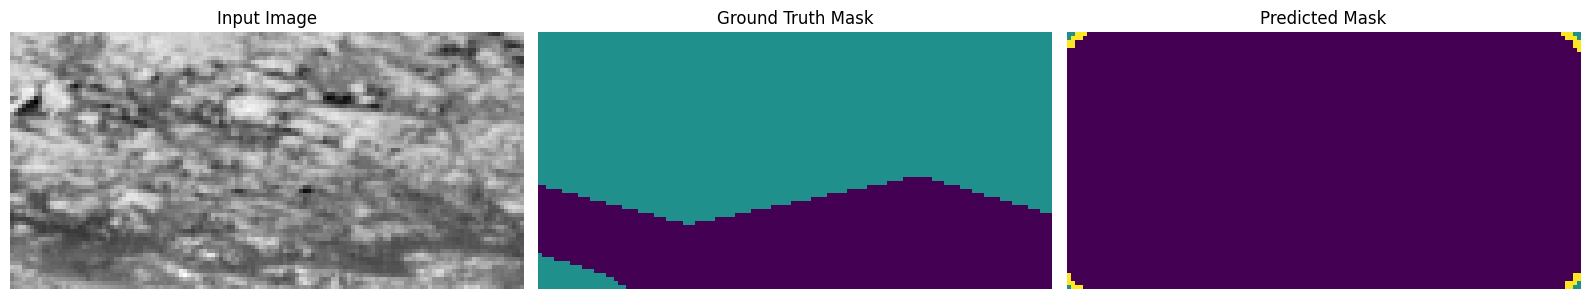

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 386ms/step - accuracy: 0.3892 - loss: 1.2034 - mean_iou: 0.2245 - val_accuracy: 0.2420 - val_loss: 1.6737 - val_mean_iou: 3.4145e-04
Epoch 7/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 366ms/step - accuracy: 0.3887 - loss: 1.2040 - mean_iou: 0.2260 - val_accuracy: 0.2173 - val_loss: 1.7327 - val_mean_iou: 0.0031
Epoch 8/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.4181 - loss: 1.1945 - mean_iou: 0.2398 - val_accuracy: 0.2179 - val_loss: 1.7701 - val_mean_iou: 0.0025
Epoch 9/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 355ms/step - accuracy: 0.3766 - loss: 1.2054 - mean_iou: 0.2802 - val_accuracy: 0.3224 - val_loss: 1.4743 - val_mean_iou: 0.1178
Epoch 10/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.4174 - loss: 1.1906 - mean_iou: 0.3022 - val_accuracy: 0.2329 - val_loss: 1.5182 - val_mean_iou: 0.0862
Epoch 11/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.3969 - loss: 1.1843 - mean_iou: 0.2896

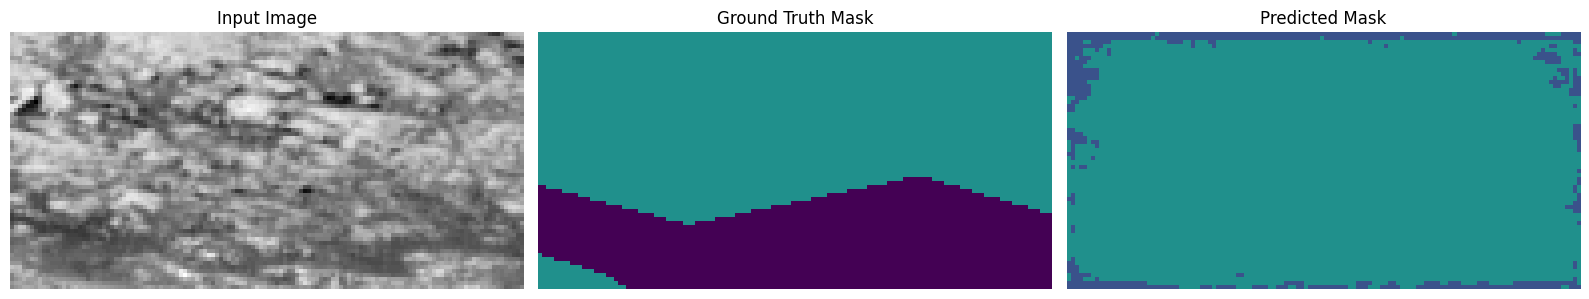

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.3970 - loss: 1.1842 - mean_iou: 0.2897 - val_accuracy: 0.2463 - val_loss: 1.3759 - val_mean_iou: 0.0993
Epoch 12/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.4011 - loss: 1.1777 - mean_iou: 0.2906 - val_accuracy: 0.2422 - val_loss: 1.3819 - val_mean_iou: 0.0802
Epoch 13/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - accuracy: 0.4358 - loss: 1.1811 - mean_iou: 0.3142 - val_accuracy: 0.2441 - val_loss: 1.3698 - val_mean_iou: 0.0832
Epoch 14/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.4342 - loss: 1.1813 - mean_iou: 0.3143 - val_accuracy: 0.3456 - val_loss: 1.3422 - val_mean_iou: 0.1969
Epoch 15/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 362ms/step - accuracy: 0.3966 - loss: 1.1831 - mean_iou: 0.2847 - val_accuracy: 0.3299 - val_loss: 1.3791 - val_mean_iou: 0.1116
Epoch 16/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.4225 - loss: 1.1901 - mean_iou: 0.2865

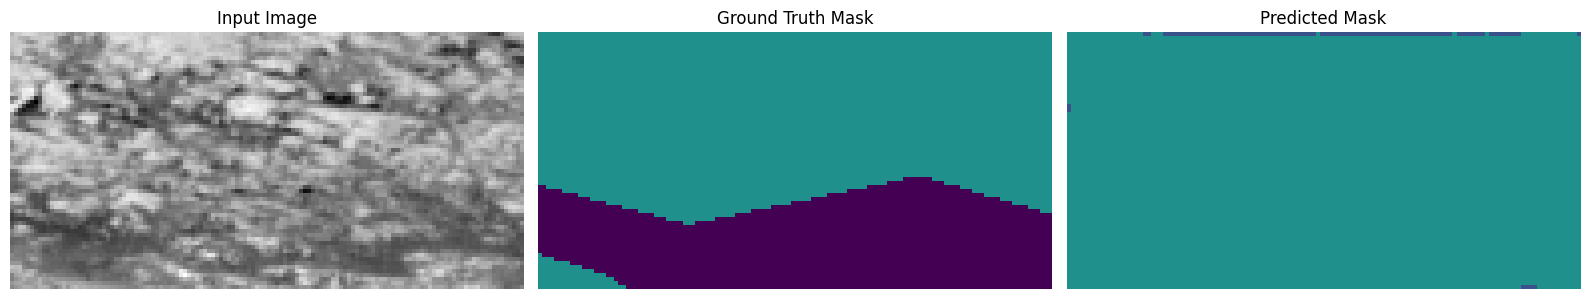

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 361ms/step - accuracy: 0.4220 - loss: 1.1900 - mean_iou: 0.2868 - val_accuracy: 0.2558 - val_loss: 1.3485 - val_mean_iou: 0.1010
Epoch 17/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 364ms/step - accuracy: 0.4265 - loss: 1.1822 - mean_iou: 0.3095 - val_accuracy: 0.3006 - val_loss: 1.3168 - val_mean_iou: 0.1561
Epoch 18/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.4517 - loss: 1.1771 - mean_iou: 0.3255 - val_accuracy: 0.2469 - val_loss: 1.3438 - val_mean_iou: 0.0870
Epoch 19/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 353ms/step - accuracy: 0.4454 - loss: 1.1775 - mean_iou: 0.3184 - val_accuracy: 0.2776 - val_loss: 1.3055 - val_mean_iou: 0.1333
Epoch 20/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - accuracy: 0.4262 - loss: 1.1798 - mean_iou: 0.3141 - val_accuracy: 0.2835 - val_loss: 1.3312 - val_mean_iou: 0.1388
Epoch 21/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.4266 - loss: 1.1849 - mean_iou: 0.2975

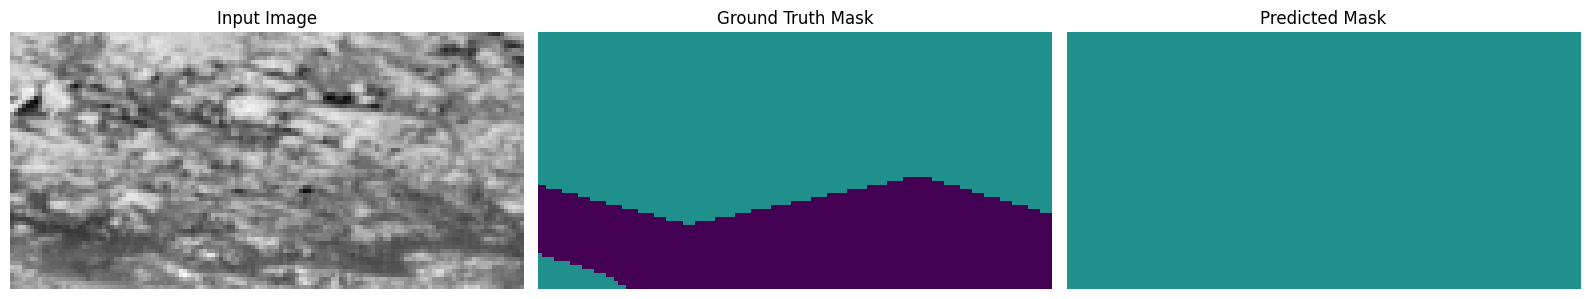

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4265 - loss: 1.1849 - mean_iou: 0.2979 - val_accuracy: 0.2516 - val_loss: 1.3284 - val_mean_iou: 0.0952
Epoch 22/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.4346 - loss: 1.1886 - mean_iou: 0.3133 - val_accuracy: 0.3064 - val_loss: 1.2823 - val_mean_iou: 0.1757
Epoch 23/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 357ms/step - accuracy: 0.4518 - loss: 1.1869 - mean_iou: 0.3338 - val_accuracy: 0.3959 - val_loss: 1.2571 - val_mean_iou: 0.2515
Epoch 24/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 372ms/step - accuracy: 0.4812 - loss: 1.1659 - mean_iou: 0.3602 - val_accuracy: 0.4242 - val_loss: 1.3165 - val_mean_iou: 0.2678
Epoch 25/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.4828 - loss: 1.1724 - mean_iou: 0.3594 - val_accuracy: 0.4008 - val_loss: 1.3572 - val_mean_iou: 0.2215
Epoch 26/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.5116 - loss: 1.1591 - mean_iou: 0.3903

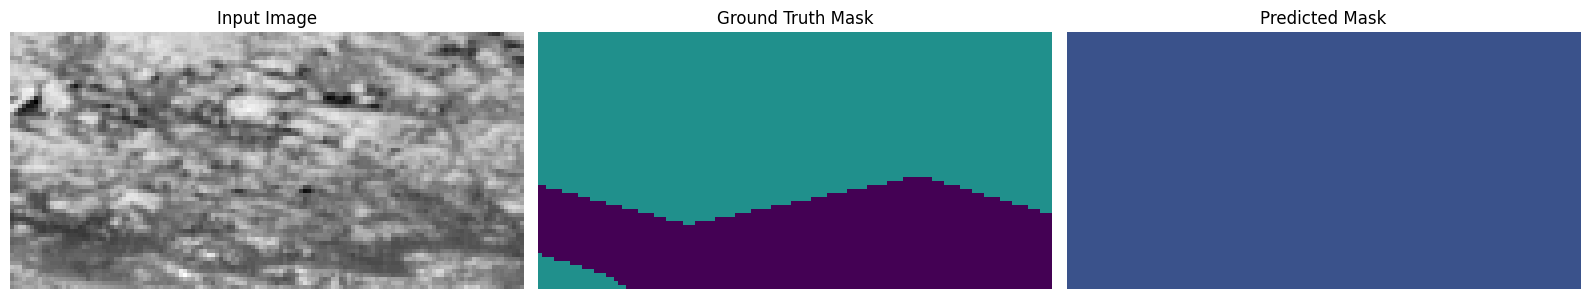

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step - accuracy: 0.5118 - loss: 1.1589 - mean_iou: 0.3905 - val_accuracy: 0.4205 - val_loss: 1.3295 - val_mean_iou: 0.2491
Epoch 27/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.5290 - loss: 1.1429 - mean_iou: 0.4107 - val_accuracy: 0.4374 - val_loss: 1.3129 - val_mean_iou: 0.2764
Epoch 28/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 357ms/step - accuracy: 0.5294 - loss: 1.1519 - mean_iou: 0.4119 - val_accuracy: 0.5285 - val_loss: 1.1876 - val_mean_iou: 0.3923
Epoch 29/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.5611 - loss: 1.1248 - mean_iou: 0.4480 - val_accuracy: 0.4615 - val_loss: 1.2831 - val_mean_iou: 0.3026
Epoch 30/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.5716 - loss: 1.1147 - mean_iou: 0.4522 - val_accuracy: 0.3877 - val_loss: 1.3946 - val_mean_iou: 0.2204
Epoch 31/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.5706 - loss: 1.1072 - mean_iou: 0.4533

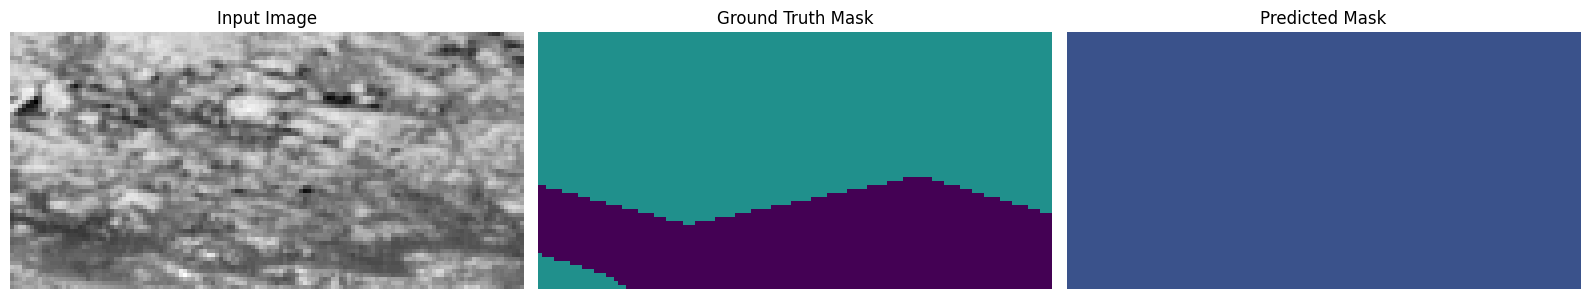

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 366ms/step - accuracy: 0.5707 - loss: 1.1069 - mean_iou: 0.4536 - val_accuracy: 0.4501 - val_loss: 1.2912 - val_mean_iou: 0.2888
Epoch 32/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 355ms/step - accuracy: 0.5753 - loss: 1.1136 - mean_iou: 0.4573 - val_accuracy: 0.4897 - val_loss: 1.2377 - val_mean_iou: 0.3378
Epoch 33/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.5833 - loss: 1.0994 - mean_iou: 0.4688 - val_accuracy: 0.4334 - val_loss: 1.2459 - val_mean_iou: 0.3060
Epoch 34/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step - accuracy: 0.5869 - loss: 1.0955 - mean_iou: 0.4715 - val_accuracy: 0.5518 - val_loss: 1.1280 - val_mean_iou: 0.4331
Epoch 35/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.5684 - loss: 1.1085 - mean_iou: 0.4500 - val_accuracy: 0.5665 - val_loss: 1.1244 - val_mean_iou: 0.4458
Epoch 36/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.5760 - loss: 1.1065 - mean_iou: 0.4554

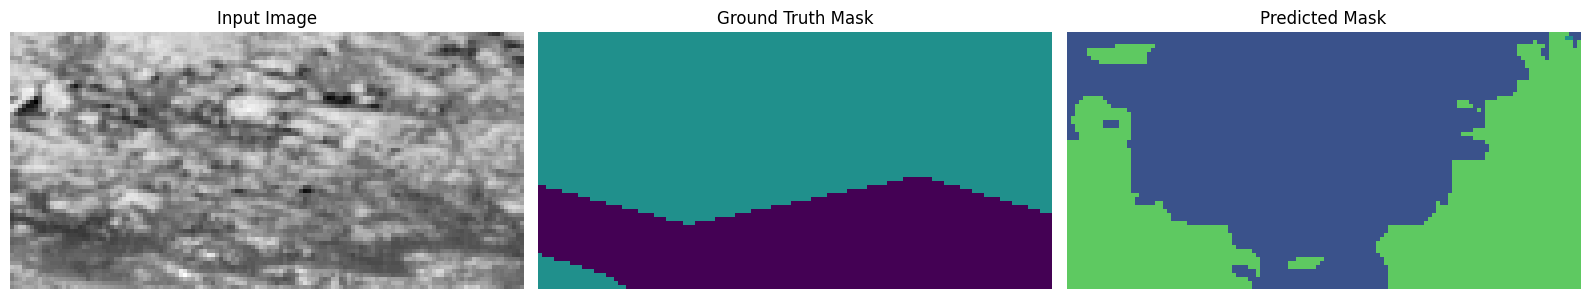

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 389ms/step - accuracy: 0.5761 - loss: 1.1061 - mean_iou: 0.4557 - val_accuracy: 0.5128 - val_loss: 1.1946 - val_mean_iou: 0.3656
Epoch 37/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 345ms/step - accuracy: 0.5826 - loss: 1.0955 - mean_iou: 0.4712 - val_accuracy: 0.3392 - val_loss: 1.4165 - val_mean_iou: 0.2126
Epoch 38/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.5736 - loss: 1.1064 - mean_iou: 0.4559 - val_accuracy: 0.3039 - val_loss: 1.4189 - val_mean_iou: 0.1641
Epoch 39/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.5759 - loss: 1.1002 - mean_iou: 0.4566 - val_accuracy: 0.6213 - val_loss: 1.0546 - val_mean_iou: 0.5254
Epoch 40/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.5948 - loss: 1.0881 - mean_iou: 0.4830 - val_accuracy: 0.6149 - val_loss: 1.0543 - val_mean_iou: 0.5148
Epoch 41/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.5774 - loss: 1.1008 - mean_iou: 0.4635

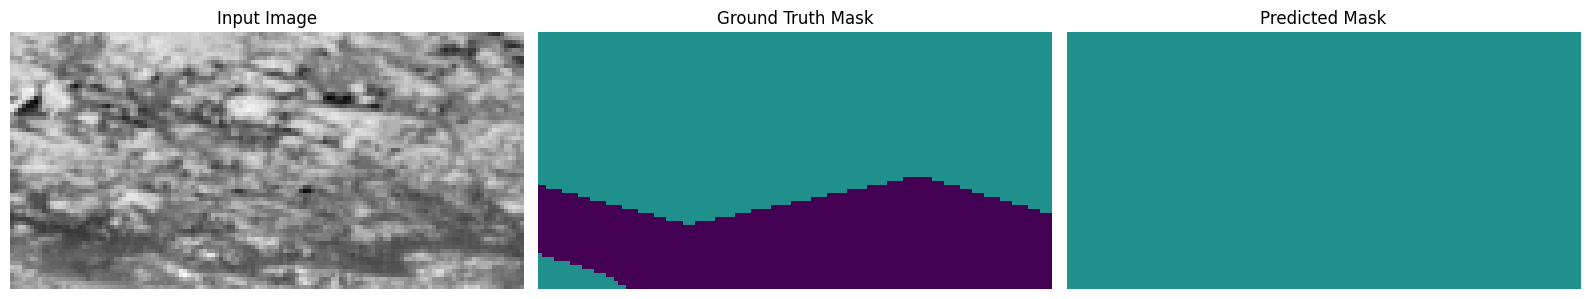

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 364ms/step - accuracy: 0.5779 - loss: 1.1003 - mean_iou: 0.4643 - val_accuracy: 0.5255 - val_loss: 1.1624 - val_mean_iou: 0.4097
Epoch 42/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 363ms/step - accuracy: 0.5897 - loss: 1.0931 - mean_iou: 0.4748 - val_accuracy: 0.5734 - val_loss: 1.0970 - val_mean_iou: 0.4641
Epoch 43/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 351ms/step - accuracy: 0.5998 - loss: 1.0810 - mean_iou: 0.4897 - val_accuracy: 0.5639 - val_loss: 1.1125 - val_mean_iou: 0.4479
Epoch 44/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - accuracy: 0.6193 - loss: 1.0604 - mean_iou: 0.5151 - val_accuracy: 0.2861 - val_loss: 1.4121 - val_mean_iou: 0.1513
Epoch 45/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 363ms/step - accuracy: 0.6015 - loss: 1.0764 - mean_iou: 0.4962 - val_accuracy: 0.1810 - val_loss: 1.6510 - val_mean_iou: 0.0602
Epoch 46/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.6008 - loss: 1.0786 - mean_iou: 0.4907

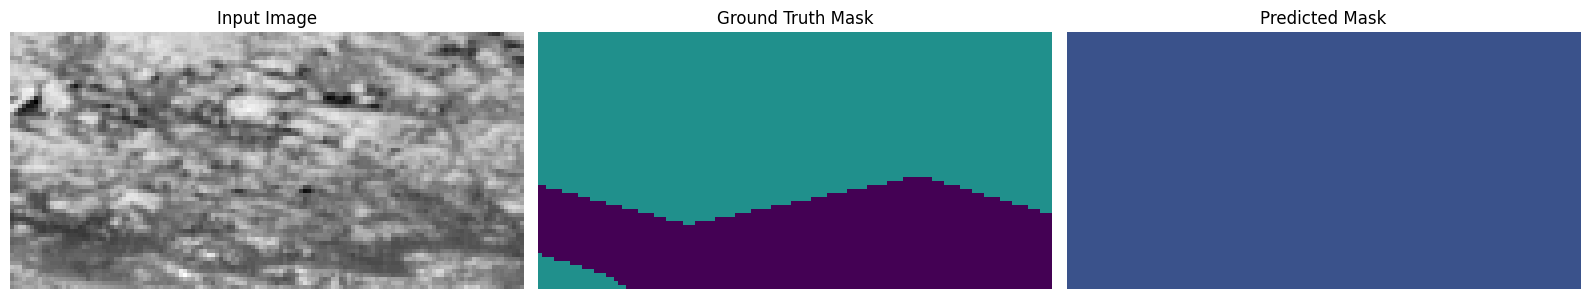

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.6011 - loss: 1.0783 - mean_iou: 0.4912 - val_accuracy: 0.4718 - val_loss: 1.2892 - val_mean_iou: 0.2985
Epoch 47/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.6028 - loss: 1.0738 - mean_iou: 0.4970 - val_accuracy: 0.2070 - val_loss: 1.5358 - val_mean_iou: 0.0871
Epoch 48/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step - accuracy: 0.6166 - loss: 1.0629 - mean_iou: 0.5098 - val_accuracy: 0.3074 - val_loss: 1.4134 - val_mean_iou: 0.1872
Epoch 49/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.5892 - loss: 1.0859 - mean_iou: 0.4797 - val_accuracy: 0.4654 - val_loss: 1.2108 - val_mean_iou: 0.3199
Epoch 50/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.6048 - loss: 1.0830 - mean_iou: 0.4930 - val_accuracy: 0.4749 - val_loss: 1.2325 - val_mean_iou: 0.3268
Epoch 51/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6068 - loss: 1.0665 - mean_iou: 0.4923

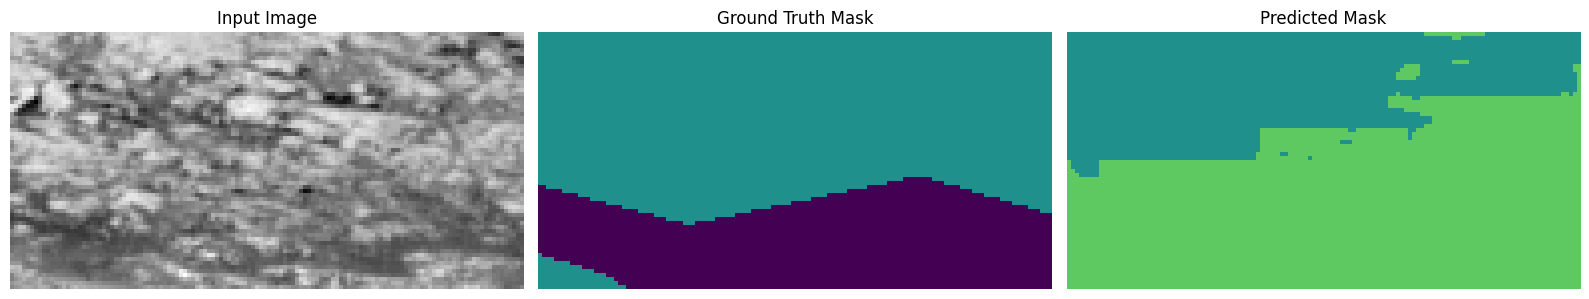

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 378ms/step - accuracy: 0.6071 - loss: 1.0661 - mean_iou: 0.4930 - val_accuracy: 0.5600 - val_loss: 1.0984 - val_mean_iou: 0.4403
Epoch 52/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.6113 - loss: 1.0658 - mean_iou: 0.5007 - val_accuracy: 0.4462 - val_loss: 1.2450 - val_mean_iou: 0.3070
Epoch 53/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 365ms/step - accuracy: 0.6074 - loss: 1.0654 - mean_iou: 0.5027 - val_accuracy: 0.5824 - val_loss: 1.1060 - val_mean_iou: 0.4645
Epoch 54/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.6189 - loss: 1.0604 - mean_iou: 0.5189 - val_accuracy: 0.5493 - val_loss: 1.1551 - val_mean_iou: 0.4270
Epoch 55/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step - accuracy: 0.6076 - loss: 1.0649 - mean_iou: 0.5006 - val_accuracy: 0.5078 - val_loss: 1.2037 - val_mean_iou: 0.3595
Epoch 56/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6182 - loss: 1.0571 - mean_iou: 0.5117

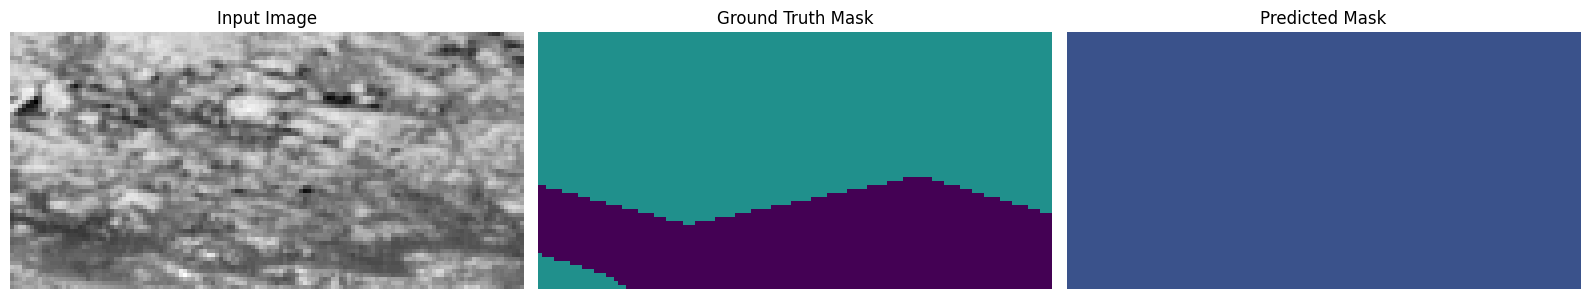

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 374ms/step - accuracy: 0.6185 - loss: 1.0567 - mean_iou: 0.5123 - val_accuracy: 0.5766 - val_loss: 1.1101 - val_mean_iou: 0.4528
Epoch 57/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 362ms/step - accuracy: 0.6295 - loss: 1.0532 - mean_iou: 0.5284 - val_accuracy: 0.5511 - val_loss: 1.1427 - val_mean_iou: 0.4266
Epoch 58/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.6097 - loss: 1.0676 - mean_iou: 0.5028 - val_accuracy: 0.6290 - val_loss: 1.0405 - val_mean_iou: 0.5360
Epoch 59/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.6196 - loss: 1.0527 - mean_iou: 0.5289 - val_accuracy: 0.5091 - val_loss: 1.2097 - val_mean_iou: 0.3638
Epoch 60/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 357ms/step - accuracy: 0.6241 - loss: 1.0496 - mean_iou: 0.5263 - val_accuracy: 0.5360 - val_loss: 1.1735 - val_mean_iou: 0.4065
Epoch 61/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6306 - loss: 1.0443 - mean_iou: 0.5294

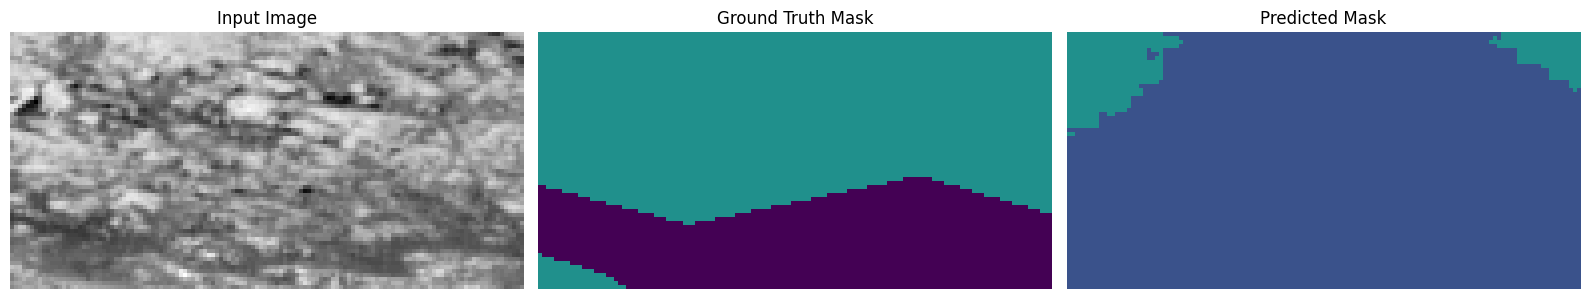

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 363ms/step - accuracy: 0.6306 - loss: 1.0442 - mean_iou: 0.5295 - val_accuracy: 0.5601 - val_loss: 1.1365 - val_mean_iou: 0.4392
Epoch 62/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 364ms/step - accuracy: 0.6197 - loss: 1.0621 - mean_iou: 0.5162 - val_accuracy: 0.5140 - val_loss: 1.1554 - val_mean_iou: 0.3907
Epoch 63/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 356ms/step - accuracy: 0.6257 - loss: 1.0494 - mean_iou: 0.5274 - val_accuracy: 0.6305 - val_loss: 1.0443 - val_mean_iou: 0.5363
Epoch 64/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.6285 - loss: 1.0456 - mean_iou: 0.5265 - val_accuracy: 0.6124 - val_loss: 1.0513 - val_mean_iou: 0.5111
Epoch 65/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step - accuracy: 0.6289 - loss: 1.0472 - mean_iou: 0.5312 - val_accuracy: 0.6480 - val_loss: 1.0262 - val_mean_iou: 0.5619
Epoch 66/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.6330 - loss: 1.0401 - mean_iou: 0.5384

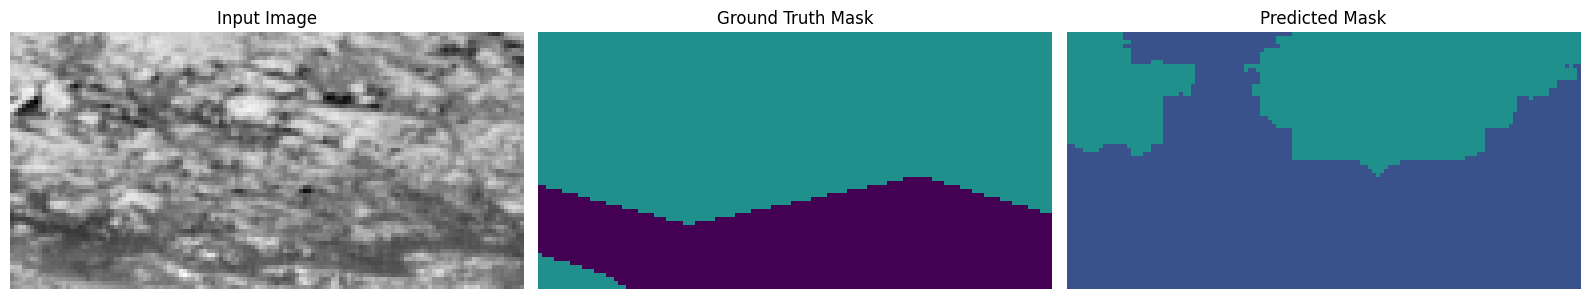

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 387ms/step - accuracy: 0.6332 - loss: 1.0399 - mean_iou: 0.5386 - val_accuracy: 0.6114 - val_loss: 1.0796 - val_mean_iou: 0.5080
Epoch 67/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.6357 - loss: 1.0375 - mean_iou: 0.5421 - val_accuracy: 0.6477 - val_loss: 1.0305 - val_mean_iou: 0.5554
Epoch 68/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 355ms/step - accuracy: 0.6403 - loss: 1.0412 - mean_iou: 0.5384 - val_accuracy: 0.5553 - val_loss: 1.1137 - val_mean_iou: 0.4275
Epoch 69/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.6335 - loss: 1.0443 - mean_iou: 0.5366 - val_accuracy: 0.6307 - val_loss: 1.0470 - val_mean_iou: 0.5364
Epoch 70/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.6416 - loss: 1.0322 - mean_iou: 0.5468 - val_accuracy: 0.6679 - val_loss: 1.0070 - val_mean_iou: 0.5944
Epoch 71/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.6484 - loss: 1.0254 - mean_iou: 0.5549

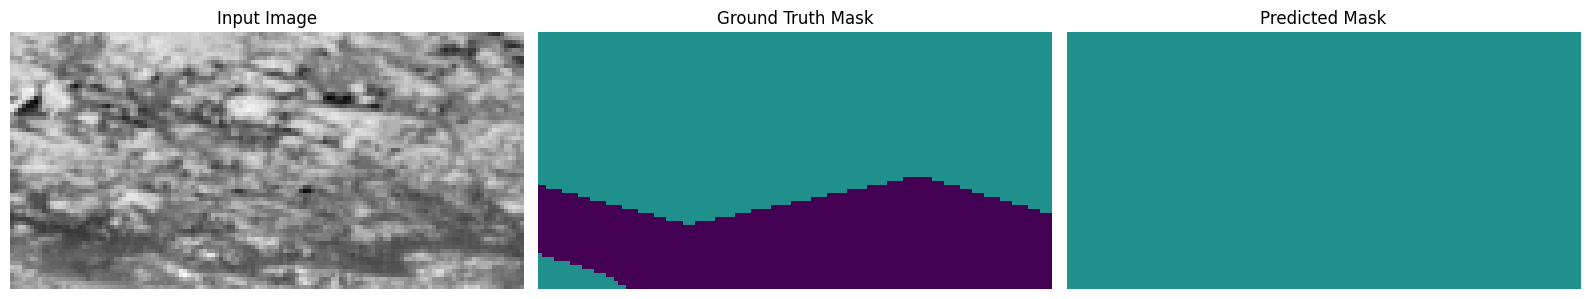

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 376ms/step - accuracy: 0.6482 - loss: 1.0254 - mean_iou: 0.5549 - val_accuracy: 0.6354 - val_loss: 1.0434 - val_mean_iou: 0.5488
Epoch 72/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.6358 - loss: 1.0387 - mean_iou: 0.5382 - val_accuracy: 0.6523 - val_loss: 1.0222 - val_mean_iou: 0.5737
Epoch 73/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - accuracy: 0.6321 - loss: 1.0405 - mean_iou: 0.5342 - val_accuracy: 0.6616 - val_loss: 1.0171 - val_mean_iou: 0.5860
Epoch 74/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 355ms/step - accuracy: 0.6524 - loss: 1.0258 - mean_iou: 0.5607 - val_accuracy: 0.4422 - val_loss: 1.2273 - val_mean_iou: 0.3007
Epoch 75/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step - accuracy: 0.6175 - loss: 1.0601 - mean_iou: 0.5154 - val_accuracy: 0.4881 - val_loss: 1.1756 - val_mean_iou: 0.3604
Epoch 76/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6357 - loss: 1.0408 - mean_iou: 0.5393

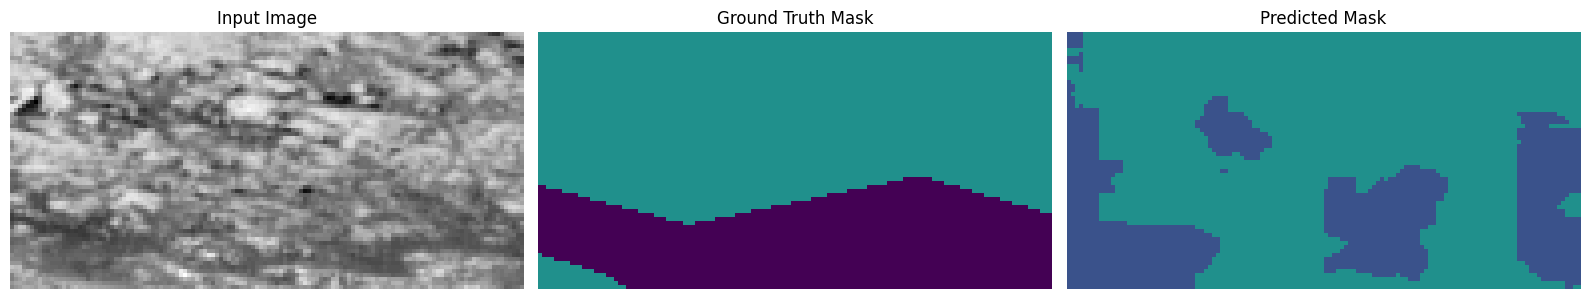

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 378ms/step - accuracy: 0.6360 - loss: 1.0405 - mean_iou: 0.5397 - val_accuracy: 0.6452 - val_loss: 1.0369 - val_mean_iou: 0.5623
Epoch 77/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 350ms/step - accuracy: 0.6416 - loss: 1.0309 - mean_iou: 0.5478 - val_accuracy: 0.5687 - val_loss: 1.1106 - val_mean_iou: 0.4538
Epoch 78/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 357ms/step - accuracy: 0.6418 - loss: 1.0296 - mean_iou: 0.5539 - val_accuracy: 0.5745 - val_loss: 1.1014 - val_mean_iou: 0.4381
Epoch 79/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - accuracy: 0.6347 - loss: 1.0368 - mean_iou: 0.5409 - val_accuracy: 0.5947 - val_loss: 1.0933 - val_mean_iou: 0.4868
Epoch 80/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.6483 - loss: 1.0271 - mean_iou: 0.5570 - val_accuracy: 0.6588 - val_loss: 1.0078 - val_mean_iou: 0.5790
Epoch 81/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.6466 - loss: 1.0238 - mean_iou: 0.5571

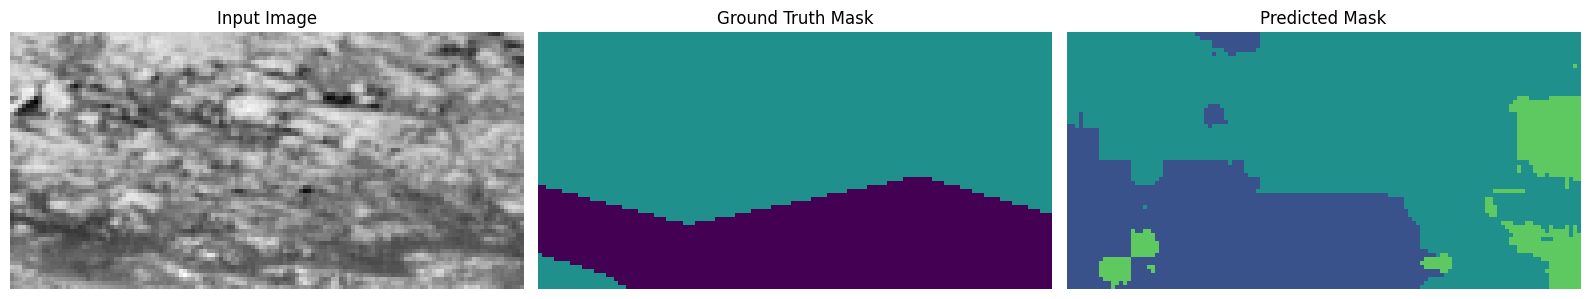

30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 386ms/step - accuracy: 0.6465 - loss: 1.0238 - mean_iou: 0.5571 - val_accuracy: 0.6260 - val_loss: 1.0471 - val_mean_iou: 0.5241
Epoch 82/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 361ms/step - accuracy: 0.6472 - loss: 1.0254 - mean_iou: 0.5549 - val_accuracy: 0.6700 - val_loss: 1.0046 - val_mean_iou: 0.5937
Epoch 83/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.6456 - loss: 1.0305 - mean_iou: 0.5472 - val_accuracy: 0.5626 - val_loss: 1.1320 - val_mean_iou: 0.4438
Epoch 84/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.6498 - loss: 1.0253 - mean_iou: 0.5586 - val_accuracy: 0.6453 - val_loss: 1.0346 - val_mean_iou: 0.5580
Epoch 85/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step - accuracy: 0.6511 - loss: 1.0242 - mean_iou: 0.5627 - val_accuracy: 0.4755 - val_loss: 1.1988 - val_mean_iou: 0.3482
Epoch 86/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.6508 - loss: 1.0244 - mean_iou: 0.5606

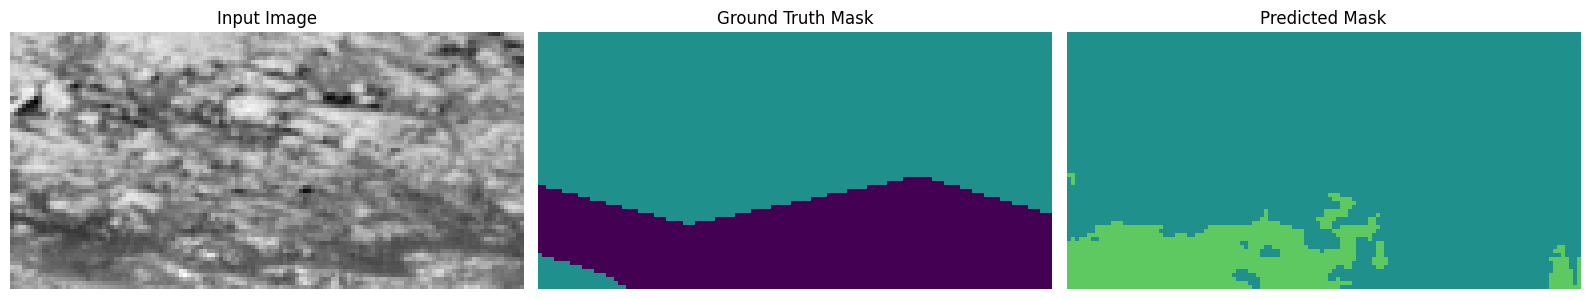

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.6507 - loss: 1.0244 - mean_iou: 0.5607 - val_accuracy: 0.6293 - val_loss: 1.0471 - val_mean_iou: 0.5332
Epoch 87/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.6389 - loss: 1.0350 - mean_iou: 0.5456 - val_accuracy: 0.6603 - val_loss: 1.0123 - val_mean_iou: 0.5827
Epoch 88/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accuracy: 0.6493 - loss: 1.0198 - mean_iou: 0.5675 - val_accuracy: 0.5622 - val_loss: 1.1203 - val_mean_iou: 0.4449
Epoch 89/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - accuracy: 0.6560 - loss: 1.0172 - mean_iou: 0.5695 - val_accuracy: 0.6625 - val_loss: 1.0064 - val_mean_iou: 0.5879
Epoch 90/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.6555 - loss: 1.0223 - mean_iou: 0.5663 - val_accuracy: 0.6070 - val_loss: 1.0582 - val_mean_iou: 0.5049
Epoch 91/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.6492 - loss: 1.0267 - mean_iou: 0.5584

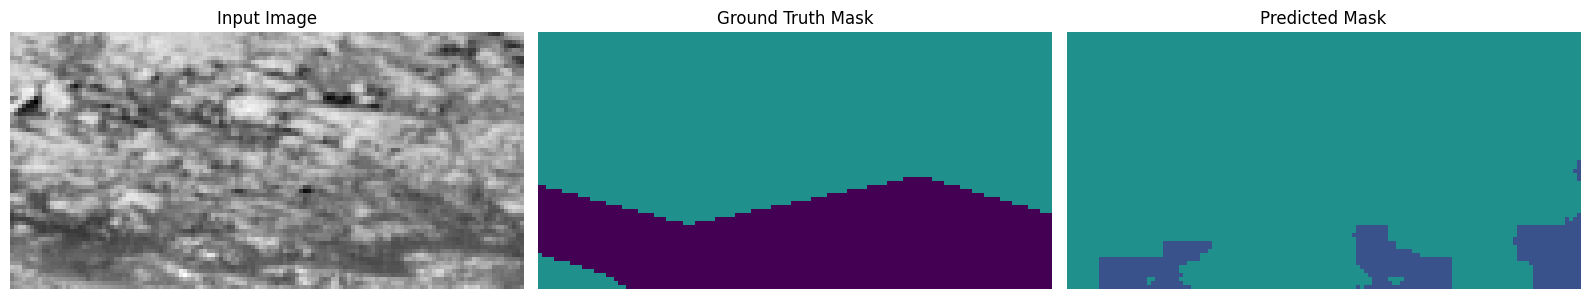

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.6492 - loss: 1.0266 - mean_iou: 0.5584 - val_accuracy: 0.6299 - val_loss: 1.0485 - val_mean_iou: 0.5354
Epoch 92/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.6455 - loss: 1.0248 - mean_iou: 0.5599 - val_accuracy: 0.5949 - val_loss: 1.0946 - val_mean_iou: 0.4910
Epoch 93/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 384ms/step - accuracy: 0.6638 - loss: 1.0098 - mean_iou: 0.5811 - val_accuracy: 0.6739 - val_loss: 0.9987 - val_mean_iou: 0.6043
Epoch 94/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.6565 - loss: 1.0152 - mean_iou: 0.5713 - val_accuracy: 0.6390 - val_loss: 1.0347 - val_mean_iou: 0.5528
Epoch 95/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 364ms/step - accuracy: 0.6425 - loss: 1.0297 - mean_iou: 0.5511 - val_accuracy: 0.6411 - val_loss: 1.0371 - val_mean_iou: 0.5496
Epoch 96/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6559 - loss: 1.0143 - mean_iou: 0.5726

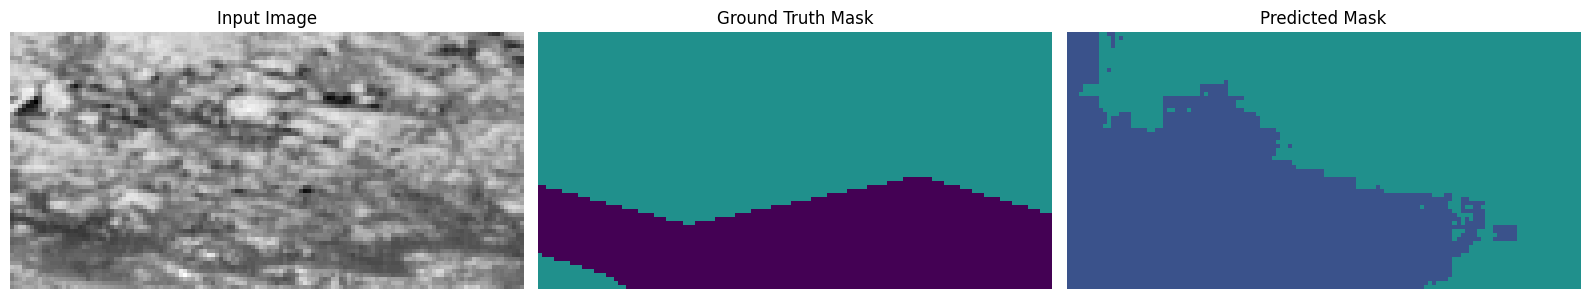

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 377ms/step - accuracy: 0.6561 - loss: 1.0140 - mean_iou: 0.5729 - val_accuracy: 0.6458 - val_loss: 1.0322 - val_mean_iou: 0.5603
Epoch 97/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 371ms/step - accuracy: 0.6669 - loss: 1.0087 - mean_iou: 0.5888 - val_accuracy: 0.6482 - val_loss: 1.0218 - val_mean_iou: 0.5634
Epoch 98/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.6570 - loss: 1.0149 - mean_iou: 0.5732 - val_accuracy: 0.6366 - val_loss: 1.0357 - val_mean_iou: 0.5481
Epoch 99/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 352ms/step - accuracy: 0.6545 - loss: 1.0225 - mean_iou: 0.5719 - val_accuracy: 0.4640 - val_loss: 1.1908 - val_mean_iou: 0.3583
Epoch 100/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 357ms/step - accuracy: 0.6555 - loss: 1.0208 - mean_iou: 0.5749 - val_accuracy: 0.6253 - val_loss: 1.0547 - val_mean_iou: 0.5234
Epoch 101/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.6571 - loss: 1.0158 - mean_iou: 0.5730

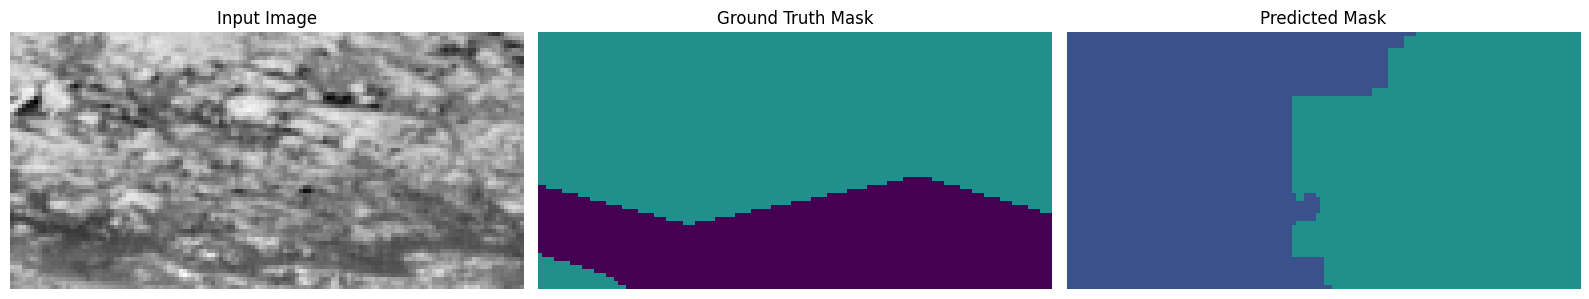

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.6570 - loss: 1.0158 - mean_iou: 0.5729 - val_accuracy: 0.6526 - val_loss: 1.0283 - val_mean_iou: 0.5688
Epoch 102/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.6491 - loss: 1.0186 - mean_iou: 0.5625 - val_accuracy: 0.6699 - val_loss: 0.9974 - val_mean_iou: 0.5974
Epoch 103/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 355ms/step - accuracy: 0.6572 - loss: 1.0146 - mean_iou: 0.5731 - val_accuracy: 0.6482 - val_loss: 1.0175 - val_mean_iou: 0.5646
Epoch 104/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 362ms/step - accuracy: 0.6618 - loss: 1.0100 - mean_iou: 0.5827 - val_accuracy: 0.6298 - val_loss: 1.0446 - val_mean_iou: 0.5302
Epoch 105/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.6571 - loss: 1.0130 - mean_iou: 0.5752 - val_accuracy: 0.6492 - val_loss: 1.0234 - val_mean_iou: 0.5640
Epoch 106/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.6652 - loss: 1.0092 - mean_iou: 0.5814

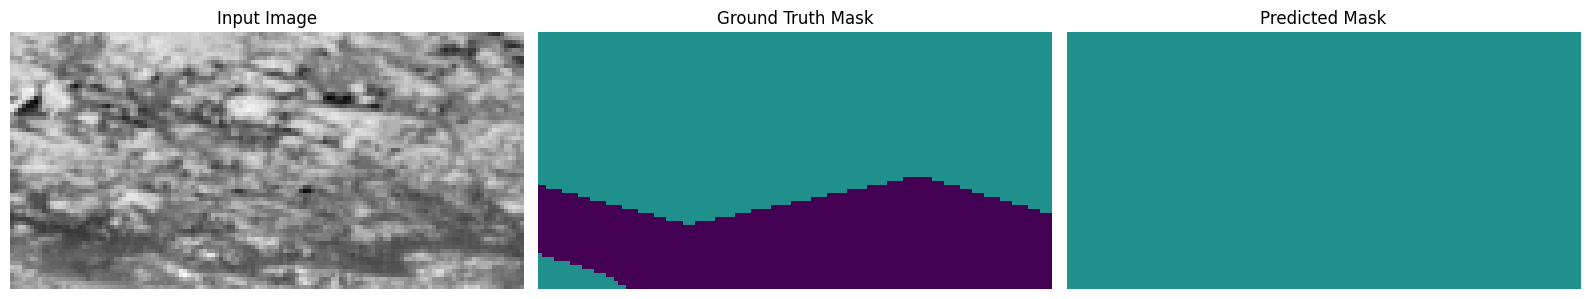

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 374ms/step - accuracy: 0.6651 - loss: 1.0092 - mean_iou: 0.5815 - val_accuracy: 0.6632 - val_loss: 1.0100 - val_mean_iou: 0.5860
Epoch 107/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - accuracy: 0.6588 - loss: 1.0117 - mean_iou: 0.5749 - val_accuracy: 0.6722 - val_loss: 1.0012 - val_mean_iou: 0.6001
Epoch 108/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 364ms/step - accuracy: 0.6576 - loss: 1.0143 - mean_iou: 0.5762 - val_accuracy: 0.6807 - val_loss: 0.9900 - val_mean_iou: 0.6146
Epoch 109/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.6638 - loss: 1.0070 - mean_iou: 0.5831 - val_accuracy: 0.6252 - val_loss: 1.0428 - val_mean_iou: 0.5379
Epoch 110/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.6567 - loss: 1.0137 - mean_iou: 0.5783 - val_accuracy: 0.6549 - val_loss: 1.0163 - val_mean_iou: 0.5700
Epoch 111/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.6612 - loss: 1.0115 - mean_iou: 0.5860

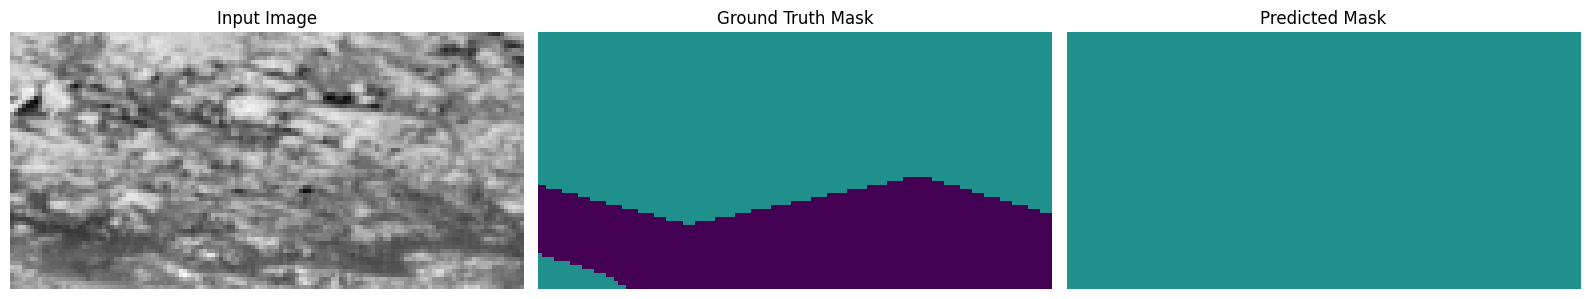

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.6615 - loss: 1.0112 - mean_iou: 0.5861 - val_accuracy: 0.6210 - val_loss: 1.0519 - val_mean_iou: 0.5221
Epoch 112/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.6572 - loss: 1.0147 - mean_iou: 0.5731 - val_accuracy: 0.6714 - val_loss: 0.9976 - val_mean_iou: 0.6017
Epoch 113/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step - accuracy: 0.6697 - loss: 1.0041 - mean_iou: 0.5901 - val_accuracy: 0.6648 - val_loss: 1.0056 - val_mean_iou: 0.5886
Epoch 114/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 351ms/step - accuracy: 0.6701 - loss: 1.0011 - mean_iou: 0.5860 - val_accuracy: 0.6524 - val_loss: 1.0234 - val_mean_iou: 0.5712
Epoch 115/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.6630 - loss: 1.0044 - mean_iou: 0.5869 - val_accuracy: 0.6673 - val_loss: 1.0039 - val_mean_iou: 0.5928
Epoch 116/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6680 - loss: 1.0034 - mean_iou: 0.5853

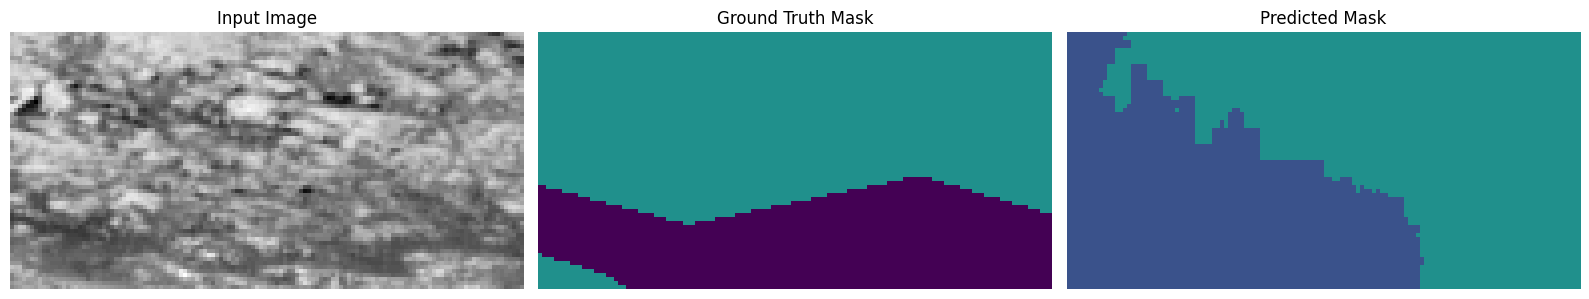

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.6679 - loss: 1.0034 - mean_iou: 0.5852 - val_accuracy: 0.6336 - val_loss: 1.0310 - val_mean_iou: 0.5460
Epoch 117/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 361ms/step - accuracy: 0.6560 - loss: 1.0162 - mean_iou: 0.5732 - val_accuracy: 0.6540 - val_loss: 1.0214 - val_mean_iou: 0.5727
Epoch 118/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.6652 - loss: 1.0070 - mean_iou: 0.5922 - val_accuracy: 0.6565 - val_loss: 1.0120 - val_mean_iou: 0.5774
Epoch 119/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - accuracy: 0.6603 - loss: 1.0086 - mean_iou: 0.5814 - val_accuracy: 0.6744 - val_loss: 0.9977 - val_mean_iou: 0.6015
Epoch 120/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 357ms/step - accuracy: 0.6634 - loss: 1.0129 - mean_iou: 0.5764 - val_accuracy: 0.6833 - val_loss: 0.9897 - val_mean_iou: 0.6174
Epoch 121/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.6780 - loss: 0.9993 - mean_iou: 0.6072

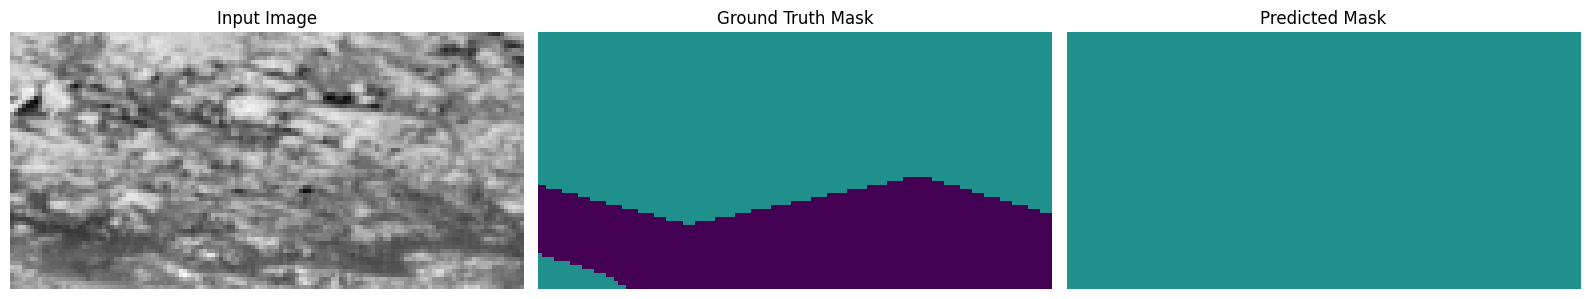

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.6778 - loss: 0.9993 - mean_iou: 0.6070 - val_accuracy: 0.6667 - val_loss: 1.0048 - val_mean_iou: 0.5926
Epoch 122/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - accuracy: 0.6737 - loss: 1.0015 - mean_iou: 0.5915 - val_accuracy: 0.6864 - val_loss: 0.9937 - val_mean_iou: 0.6238
Epoch 123/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 354ms/step - accuracy: 0.6811 - loss: 0.9901 - mean_iou: 0.6084 - val_accuracy: 0.6808 - val_loss: 0.9947 - val_mean_iou: 0.6130
Epoch 124/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 363ms/step - accuracy: 0.6658 - loss: 1.0012 - mean_iou: 0.5921 - val_accuracy: 0.6565 - val_loss: 1.0165 - val_mean_iou: 0.5746
Epoch 125/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.6707 - loss: 1.0062 - mean_iou: 0.5872 - val_accuracy: 0.6216 - val_loss: 1.0445 - val_mean_iou: 0.5261
Epoch 126/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.6646 - loss: 1.0032 - mean_iou: 0.5866

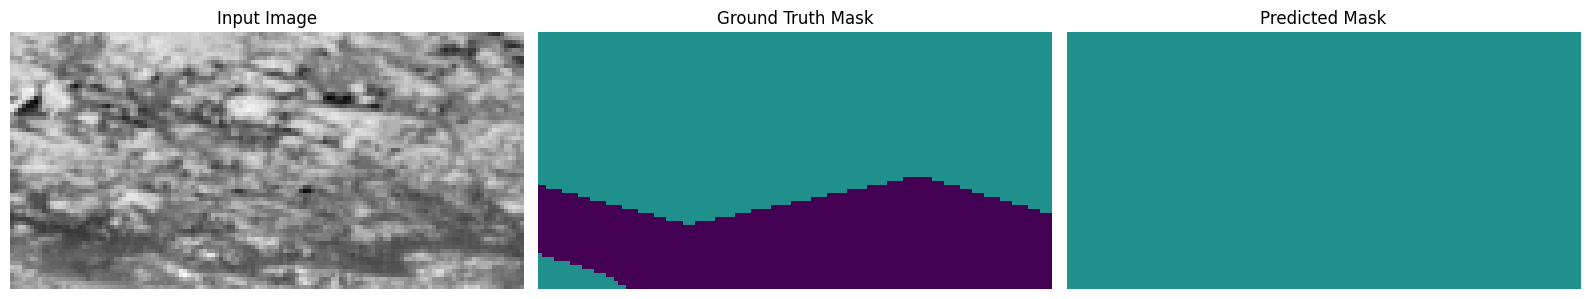

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 395ms/step - accuracy: 0.6648 - loss: 1.0030 - mean_iou: 0.5869 - val_accuracy: 0.6668 - val_loss: 1.0138 - val_mean_iou: 0.5921
Epoch 127/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 359ms/step - accuracy: 0.6759 - loss: 1.0026 - mean_iou: 0.5968 - val_accuracy: 0.6548 - val_loss: 1.0033 - val_mean_iou: 0.5706
Epoch 128/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 370ms/step - accuracy: 0.6709 - loss: 1.0011 - mean_iou: 0.5938 - val_accuracy: 0.6036 - val_loss: 1.0594 - val_mean_iou: 0.5006
Epoch 129/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.6673 - loss: 1.0039 - mean_iou: 0.5883 - val_accuracy: 0.6858 - val_loss: 0.9814 - val_mean_iou: 0.6225
Epoch 130/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - accuracy: 0.6772 - loss: 0.9998 - mean_iou: 0.6032 - val_accuracy: 0.6790 - val_loss: 0.9927 - val_mean_iou: 0.6110
Epoch 131/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.6733 - loss: 0.9970 - mean_iou: 0.5999

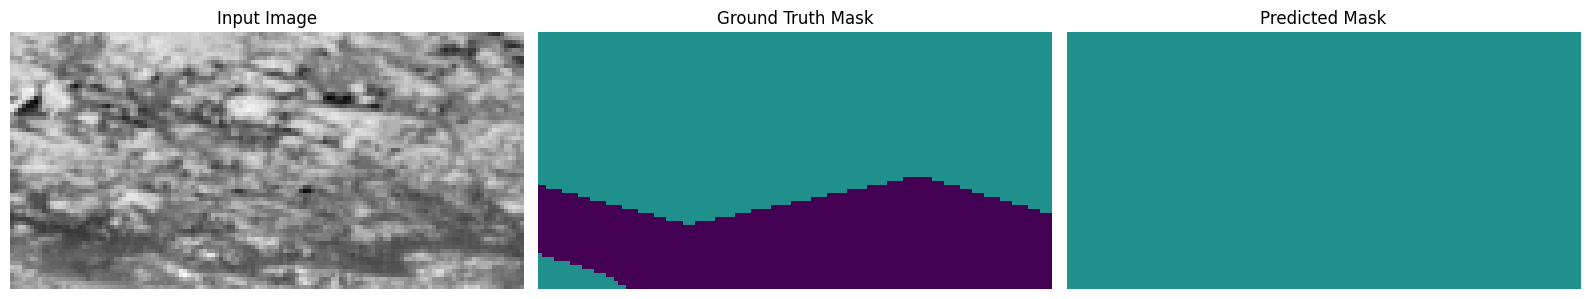

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.6733 - loss: 0.9970 - mean_iou: 0.5999 - val_accuracy: 0.6799 - val_loss: 0.9897 - val_mean_iou: 0.6132
Epoch 132/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step - accuracy: 0.6736 - loss: 1.0000 - mean_iou: 0.5962 - val_accuracy: 0.6877 - val_loss: 0.9890 - val_mean_iou: 0.6251
Epoch 133/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accuracy: 0.6715 - loss: 1.0011 - mean_iou: 0.5913 - val_accuracy: 0.6808 - val_loss: 0.9888 - val_mean_iou: 0.6125
Epoch 134/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.6744 - loss: 0.9999 - mean_iou: 0.5954 - val_accuracy: 0.6794 - val_loss: 0.9955 - val_mean_iou: 0.6122
Epoch 135/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 364ms/step - accuracy: 0.6764 - loss: 0.9942 - mean_iou: 0.6068 - val_accuracy: 0.6759 - val_loss: 0.9927 - val_mean_iou: 0.6072
Epoch 136/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6742 - loss: 0.9951 - mean_iou: 0.6007

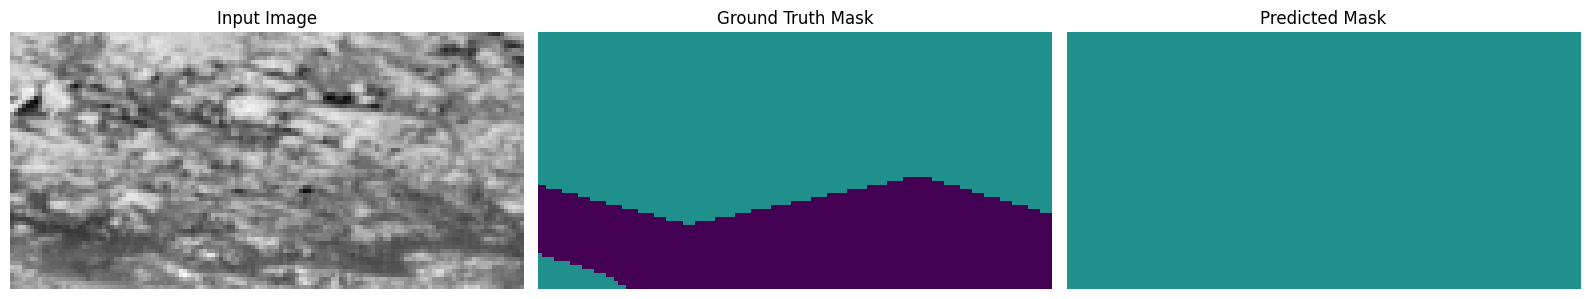

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 363ms/step - accuracy: 0.6744 - loss: 0.9949 - mean_iou: 0.6009 - val_accuracy: 0.6622 - val_loss: 1.0138 - val_mean_iou: 0.5875
Epoch 137/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.6768 - loss: 0.9965 - mean_iou: 0.5980 - val_accuracy: 0.6636 - val_loss: 1.0109 - val_mean_iou: 0.5863
Epoch 138/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 362ms/step - accuracy: 0.6818 - loss: 0.9906 - mean_iou: 0.6092 - val_accuracy: 0.6637 - val_loss: 1.0078 - val_mean_iou: 0.5880
Epoch 139/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 361ms/step - accuracy: 0.6799 - loss: 0.9930 - mean_iou: 0.6050 - val_accuracy: 0.6721 - val_loss: 0.9903 - val_mean_iou: 0.6001
Epoch 140/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 364ms/step - accuracy: 0.6730 - loss: 0.9946 - mean_iou: 0.5993 - val_accuracy: 0.6707 - val_loss: 1.0038 - val_mean_iou: 0.5963
Epoch 141/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6822 - loss: 0.9921 - mean_iou: 0.6075

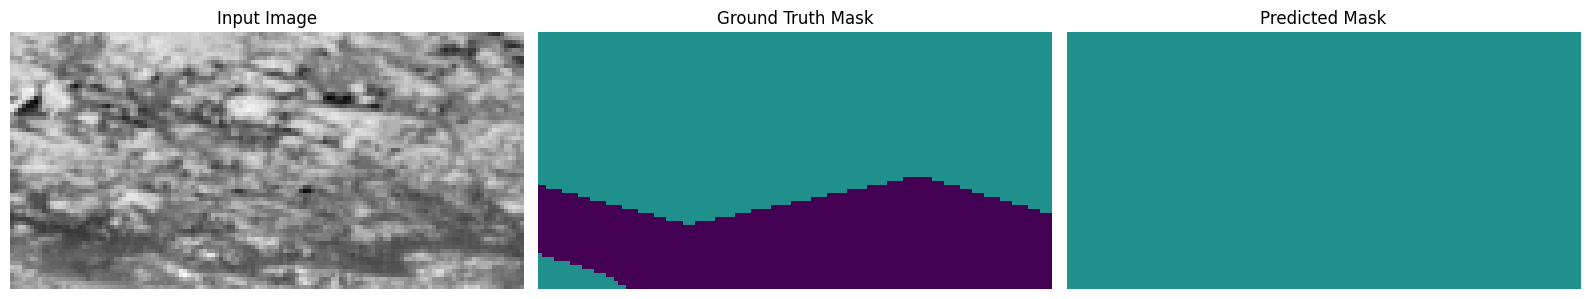

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 375ms/step - accuracy: 0.6822 - loss: 0.9919 - mean_iou: 0.6077 - val_accuracy: 0.6734 - val_loss: 0.9932 - val_mean_iou: 0.6039
Epoch 142/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 365ms/step - accuracy: 0.6769 - loss: 0.9928 - mean_iou: 0.6100 - val_accuracy: 0.6574 - val_loss: 1.0119 - val_mean_iou: 0.5796
Epoch 143/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step - accuracy: 0.6770 - loss: 0.9939 - mean_iou: 0.6030 - val_accuracy: 0.6743 - val_loss: 0.9964 - val_mean_iou: 0.6066
Epoch 144/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.6888 - loss: 0.9810 - mean_iou: 0.6245 - val_accuracy: 0.6717 - val_loss: 0.9943 - val_mean_iou: 0.6001
Epoch 145/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.6764 - loss: 0.9956 - mean_iou: 0.6008 - val_accuracy: 0.6666 - val_loss: 1.0032 - val_mean_iou: 0.5914
Epoch 146/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.6910 - loss: 0.9840 - mean_iou: 0.6237

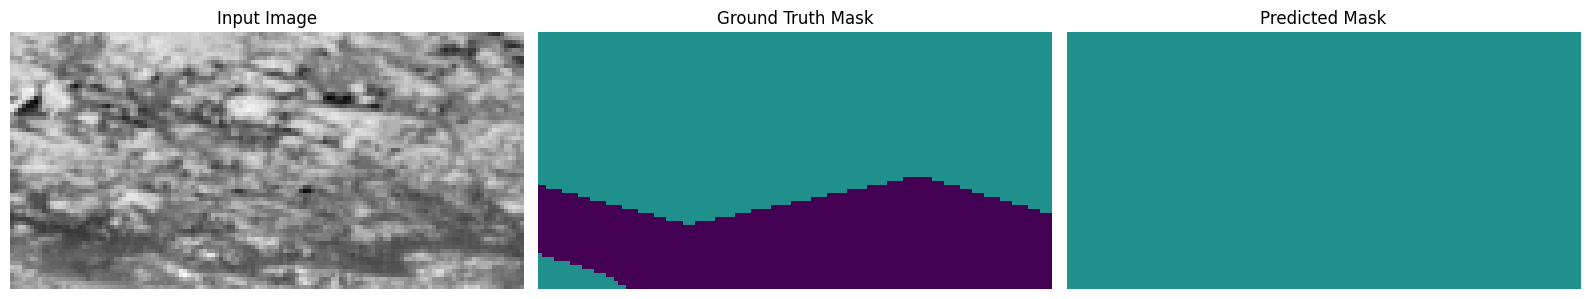

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.6909 - loss: 0.9840 - mean_iou: 0.6237 - val_accuracy: 0.6837 - val_loss: 0.9875 - val_mean_iou: 0.6199
Epoch 147/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 362ms/step - accuracy: 0.6808 - loss: 0.9865 - mean_iou: 0.6101 - val_accuracy: 0.6642 - val_loss: 1.0148 - val_mean_iou: 0.5863
Epoch 148/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6788 - loss: 0.9869 - mean_iou: 0.6099 - val_accuracy: 0.6690 - val_loss: 1.0060 - val_mean_iou: 0.5964
Epoch 149/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 355ms/step - accuracy: 0.6883 - loss: 0.9870 - mean_iou: 0.6132 - val_accuracy: 0.6789 - val_loss: 0.9918 - val_mean_iou: 0.6133
Epoch 150/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.6809 - loss: 0.9877 - mean_iou: 0.6117 - val_accuracy: 0.6476 - val_loss: 1.0113 - val_mean_iou: 0.5632
Epoch 151/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.6760 - loss: 0.9942 - mean_iou: 0.6059

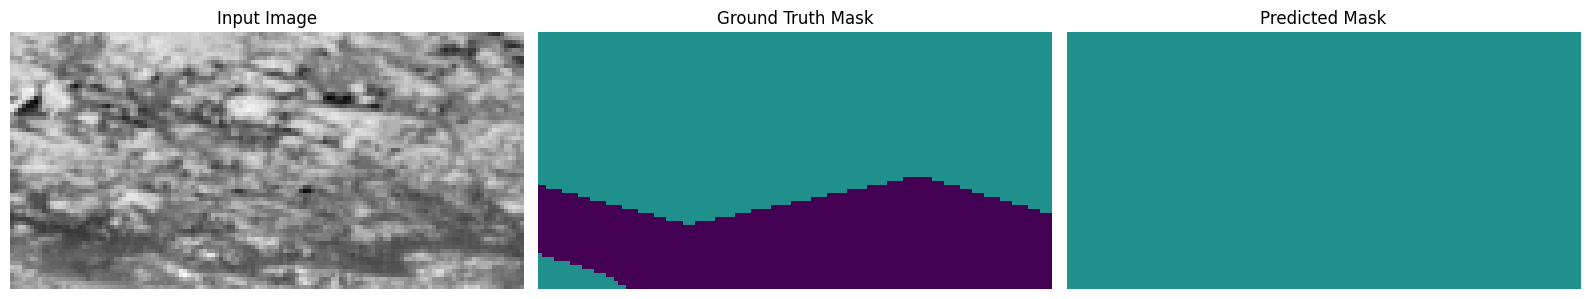

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.6763 - loss: 0.9939 - mean_iou: 0.6064 - val_accuracy: 0.6793 - val_loss: 0.9897 - val_mean_iou: 0.6117
Epoch 152/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - accuracy: 0.6787 - loss: 0.9989 - mean_iou: 0.6046 - val_accuracy: 0.6865 - val_loss: 0.9866 - val_mean_iou: 0.6244
Epoch 153/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.6840 - loss: 0.9908 - mean_iou: 0.6154 - val_accuracy: 0.6709 - val_loss: 0.9981 - val_mean_iou: 0.5996
Epoch 154/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.6840 - loss: 0.9852 - mean_iou: 0.6173 - val_accuracy: 0.6739 - val_loss: 0.9950 - val_mean_iou: 0.6044
Epoch 155/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 365ms/step - accuracy: 0.6854 - loss: 0.9880 - mean_iou: 0.6145 - val_accuracy: 0.6671 - val_loss: 1.0032 - val_mean_iou: 0.5939
Epoch 156/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.6899 - loss: 0.9837 - mean_iou: 0.6341

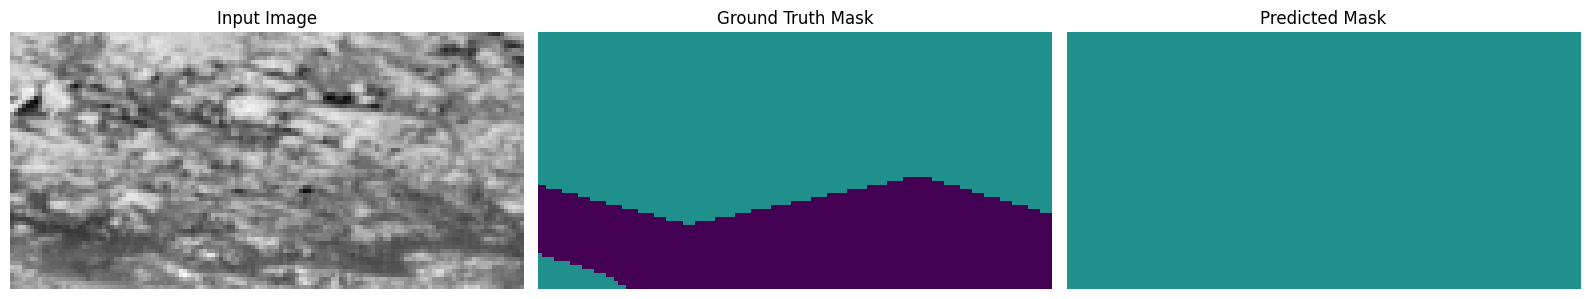

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 376ms/step - accuracy: 0.6899 - loss: 0.9836 - mean_iou: 0.6338 - val_accuracy: 0.6754 - val_loss: 0.9908 - val_mean_iou: 0.6072
Epoch 157/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.6780 - loss: 0.9909 - mean_iou: 0.6086 - val_accuracy: 0.6805 - val_loss: 0.9900 - val_mean_iou: 0.6102
Epoch 158/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.6878 - loss: 0.9821 - mean_iou: 0.6238 - val_accuracy: 0.6804 - val_loss: 0.9889 - val_mean_iou: 0.6141
Epoch 159/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step - accuracy: 0.6852 - loss: 0.9850 - mean_iou: 0.6151 - val_accuracy: 0.6715 - val_loss: 0.9984 - val_mean_iou: 0.5990
Epoch 160/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.6827 - loss: 0.9900 - mean_iou: 0.6143 - val_accuracy: 0.6859 - val_loss: 0.9799 - val_mean_iou: 0.6239
Epoch 161/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.6766 - loss: 0.9905 - mean_iou: 0.6062

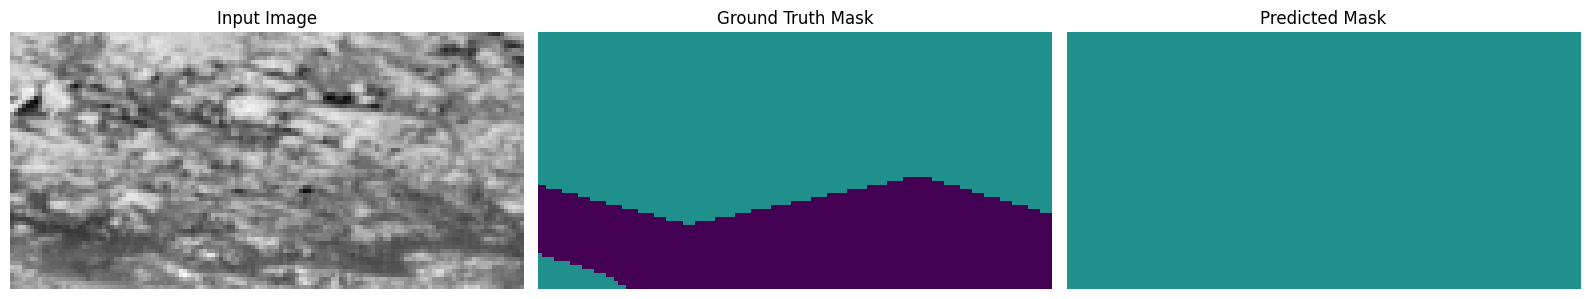

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.6765 - loss: 0.9906 - mean_iou: 0.6060 - val_accuracy: 0.6782 - val_loss: 0.9932 - val_mean_iou: 0.6096
Epoch 162/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 362ms/step - accuracy: 0.6818 - loss: 0.9901 - mean_iou: 0.6179 - val_accuracy: 0.6865 - val_loss: 0.9846 - val_mean_iou: 0.6224
Epoch 163/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.6879 - loss: 0.9836 - mean_iou: 0.6194 - val_accuracy: 0.6613 - val_loss: 0.9994 - val_mean_iou: 0.5885
Epoch 164/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.6954 - loss: 0.9767 - mean_iou: 0.6320 - val_accuracy: 0.6743 - val_loss: 1.0021 - val_mean_iou: 0.6049
Epoch 165/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.6920 - loss: 0.9810 - mean_iou: 0.6278 - val_accuracy: 0.6830 - val_loss: 0.9820 - val_mean_iou: 0.6195
Epoch 166/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.6937 - loss: 0.9775 - mean_iou: 0.6299

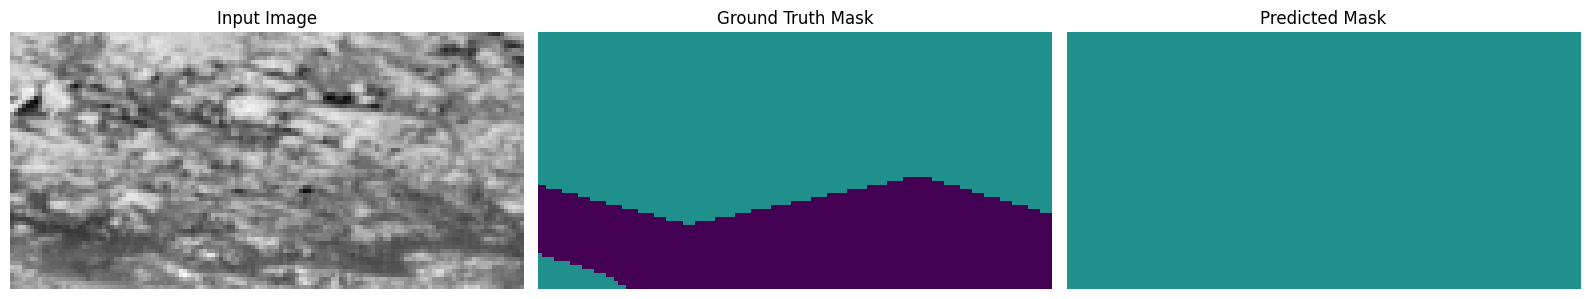

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 382ms/step - accuracy: 0.6934 - loss: 0.9777 - mean_iou: 0.6297 - val_accuracy: 0.6591 - val_loss: 1.0080 - val_mean_iou: 0.5846
Epoch 167/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 361ms/step - accuracy: 0.6874 - loss: 0.9811 - mean_iou: 0.6217 - val_accuracy: 0.6728 - val_loss: 0.9971 - val_mean_iou: 0.6009
Epoch 168/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.6819 - loss: 0.9905 - mean_iou: 0.6086 - val_accuracy: 0.6594 - val_loss: 1.0189 - val_mean_iou: 0.5828
Epoch 169/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - accuracy: 0.6899 - loss: 0.9800 - mean_iou: 0.6274 - val_accuracy: 0.6580 - val_loss: 1.0060 - val_mean_iou: 0.5817
Epoch 170/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step - accuracy: 0.6866 - loss: 0.9874 - mean_iou: 0.6126 - val_accuracy: 0.6705 - val_loss: 0.9998 - val_mean_iou: 0.5949
Epoch 171/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6863 - loss: 0.9865 - mean_iou: 0.6243

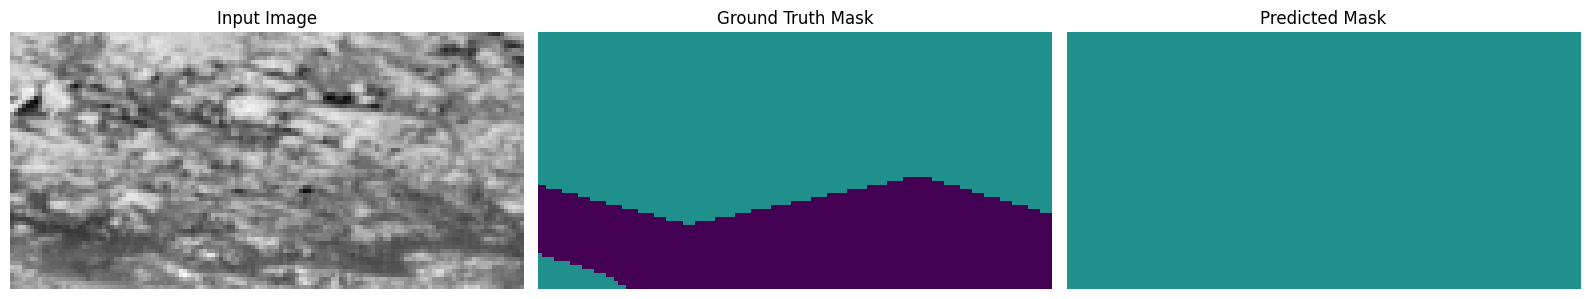

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.6864 - loss: 0.9862 - mean_iou: 0.6244 - val_accuracy: 0.6632 - val_loss: 1.0118 - val_mean_iou: 0.5848
Epoch 172/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - accuracy: 0.6952 - loss: 0.9754 - mean_iou: 0.6314 - val_accuracy: 0.6807 - val_loss: 0.9899 - val_mean_iou: 0.6154
Epoch 173/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.6889 - loss: 0.9837 - mean_iou: 0.6195 - val_accuracy: 0.6873 - val_loss: 0.9818 - val_mean_iou: 0.6253
Epoch 174/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.6859 - loss: 0.9826 - mean_iou: 0.6229 - val_accuracy: 0.6779 - val_loss: 0.9946 - val_mean_iou: 0.6084
Epoch 175/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step - accuracy: 0.6902 - loss: 0.9827 - mean_iou: 0.6204 - val_accuracy: 0.6773 - val_loss: 0.9949 - val_mean_iou: 0.6096
Epoch 176/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.6901 - loss: 0.9811 - mean_iou: 0.6227

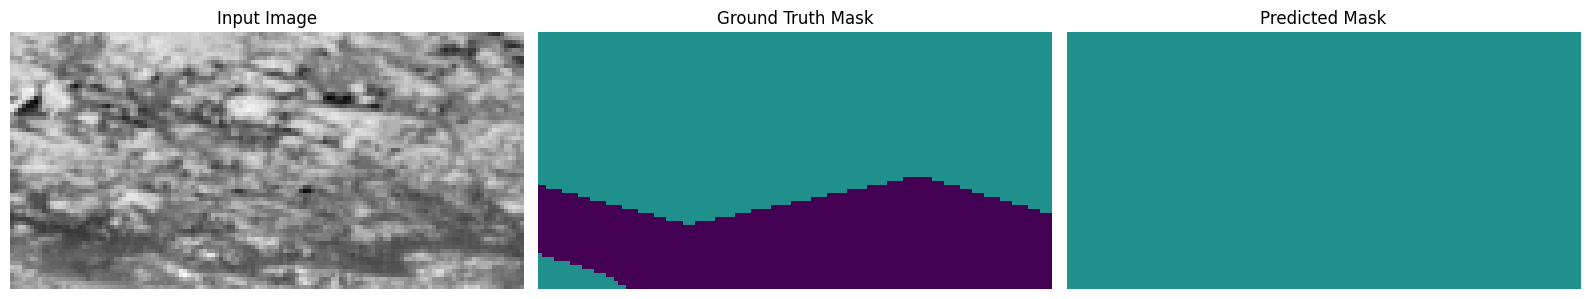

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 397ms/step - accuracy: 0.6901 - loss: 0.9811 - mean_iou: 0.6228 - val_accuracy: 0.6671 - val_loss: 0.9977 - val_mean_iou: 0.5922
Epoch 177/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 357ms/step - accuracy: 0.6903 - loss: 0.9819 - mean_iou: 0.6267 - val_accuracy: 0.6657 - val_loss: 1.0016 - val_mean_iou: 0.5919
Epoch 178/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.6858 - loss: 0.9838 - mean_iou: 0.6214 - val_accuracy: 0.6794 - val_loss: 0.9875 - val_mean_iou: 0.6133
Epoch 179/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 365ms/step - accuracy: 0.6943 - loss: 0.9803 - mean_iou: 0.6263 - val_accuracy: 0.6858 - val_loss: 0.9762 - val_mean_iou: 0.6233
Epoch 180/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.6843 - loss: 0.9850 - mean_iou: 0.6165 - val_accuracy: 0.6733 - val_loss: 0.9892 - val_mean_iou: 0.6019
Epoch 181/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6853 - loss: 0.9803 - mean_iou: 0.6251

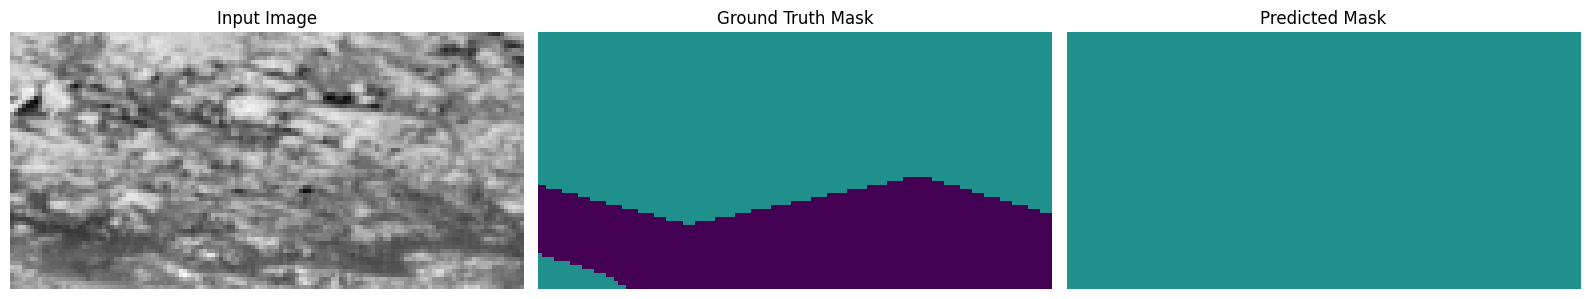

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 377ms/step - accuracy: 0.6854 - loss: 0.9801 - mean_iou: 0.6252 - val_accuracy: 0.6748 - val_loss: 0.9900 - val_mean_iou: 0.6055
Epoch 182/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 362ms/step - accuracy: 0.6985 - loss: 0.9727 - mean_iou: 0.6388 - val_accuracy: 0.6578 - val_loss: 1.0145 - val_mean_iou: 0.5716
Epoch 183/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.6940 - loss: 0.9776 - mean_iou: 0.6309 - val_accuracy: 0.6814 - val_loss: 0.9817 - val_mean_iou: 0.6171
Epoch 184/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.6878 - loss: 0.9777 - mean_iou: 0.6252 - val_accuracy: 0.6746 - val_loss: 0.9955 - val_mean_iou: 0.6035
Epoch 185/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.6955 - loss: 0.9772 - mean_iou: 0.6313 - val_accuracy: 0.6832 - val_loss: 0.9833 - val_mean_iou: 0.6187
Epoch 186/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.6879 - loss: 0.9840 - mean_iou: 0.6187

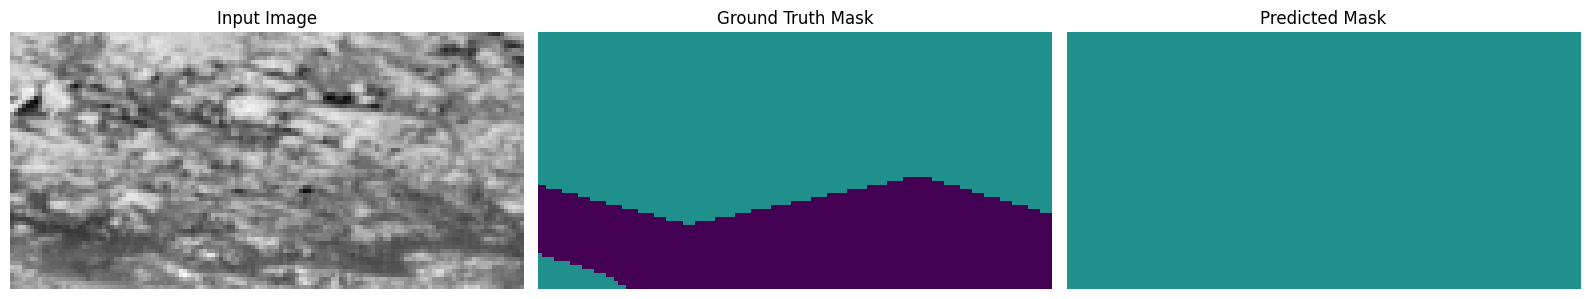

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 381ms/step - accuracy: 0.6880 - loss: 0.9837 - mean_iou: 0.6190 - val_accuracy: 0.6869 - val_loss: 0.9807 - val_mean_iou: 0.6251
Epoch 187/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.6959 - loss: 0.9715 - mean_iou: 0.6410 - val_accuracy: 0.6845 - val_loss: 0.9895 - val_mean_iou: 0.6213
Epoch 188/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step - accuracy: 0.6959 - loss: 0.9748 - mean_iou: 0.6319 - val_accuracy: 0.6860 - val_loss: 0.9802 - val_mean_iou: 0.6218
Epoch 189/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.6952 - loss: 0.9718 - mean_iou: 0.6352 - val_accuracy: 0.6712 - val_loss: 1.0019 - val_mean_iou: 0.5968
Epoch 190/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 359ms/step - accuracy: 0.6957 - loss: 0.9739 - mean_iou: 0.6343 - val_accuracy: 0.6720 - val_loss: 0.9985 - val_mean_iou: 0.6000
Epoch 191/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6962 - loss: 0.9713 - mean_iou: 0.6396

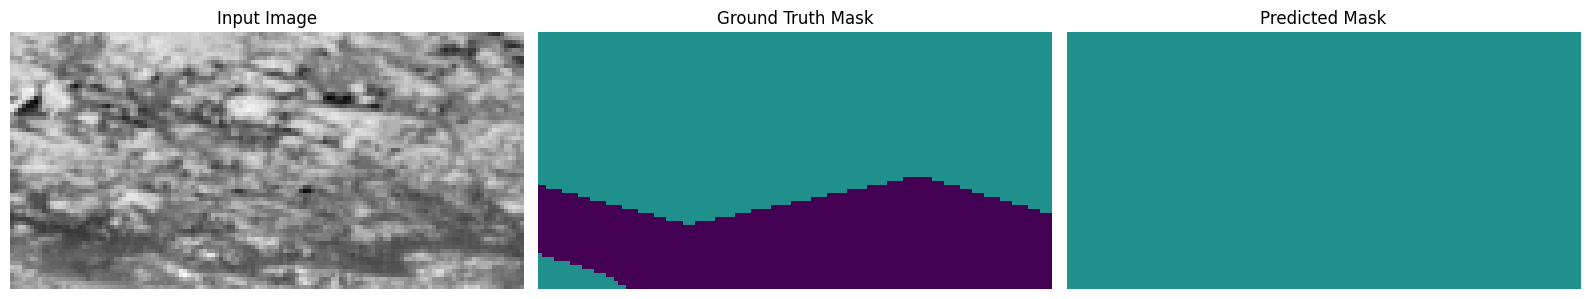

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 380ms/step - accuracy: 0.6962 - loss: 0.9713 - mean_iou: 0.6396 - val_accuracy: 0.6810 - val_loss: 0.9814 - val_mean_iou: 0.6149
Epoch 192/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 361ms/step - accuracy: 0.6846 - loss: 0.9849 - mean_iou: 0.6145 - val_accuracy: 0.6797 - val_loss: 0.9880 - val_mean_iou: 0.6112
Epoch 193/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - accuracy: 0.6875 - loss: 0.9839 - mean_iou: 0.6273 - val_accuracy: 0.6823 - val_loss: 0.9857 - val_mean_iou: 0.6177
Epoch 194/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.7013 - loss: 0.9695 - mean_iou: 0.6427 - val_accuracy: 0.6758 - val_loss: 0.9909 - val_mean_iou: 0.6046
Epoch 195/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 362ms/step - accuracy: 0.6967 - loss: 0.9755 - mean_iou: 0.6329 - val_accuracy: 0.6686 - val_loss: 0.9978 - val_mean_iou: 0.5900
Epoch 196/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.6923 - loss: 0.9791 - mean_iou: 0.6264

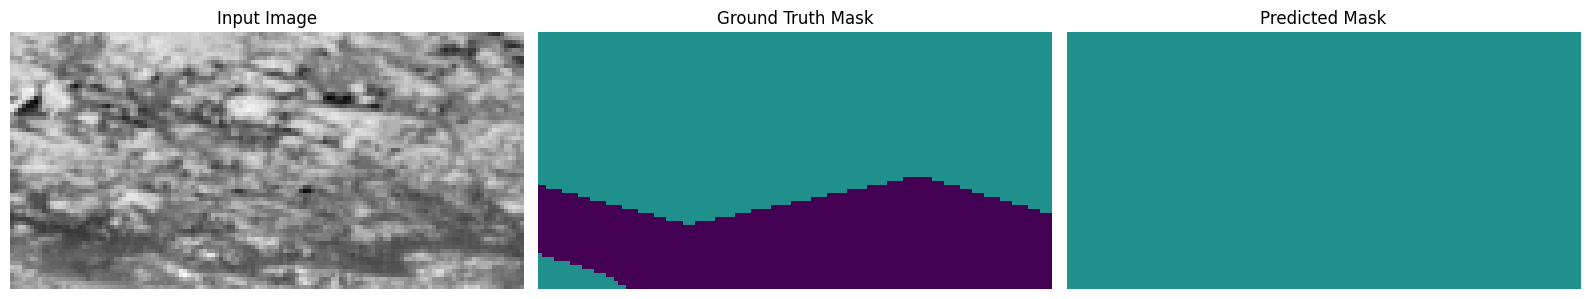

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.6924 - loss: 0.9789 - mean_iou: 0.6268 - val_accuracy: 0.6745 - val_loss: 0.9918 - val_mean_iou: 0.6027
Epoch 197/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.6944 - loss: 0.9728 - mean_iou: 0.6311 - val_accuracy: 0.6581 - val_loss: 1.0178 - val_mean_iou: 0.5811
Epoch 198/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.6948 - loss: 0.9751 - mean_iou: 0.6334 - val_accuracy: 0.6747 - val_loss: 0.9934 - val_mean_iou: 0.6026
Epoch 199/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 362ms/step - accuracy: 0.6999 - loss: 0.9683 - mean_iou: 0.6442 - val_accuracy: 0.6667 - val_loss: 1.0066 - val_mean_iou: 0.5915
Epoch 200/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 362ms/step - accuracy: 0.6933 - loss: 0.9754 - mean_iou: 0.6302 - val_accuracy: 0.6855 - val_loss: 0.9825 - val_mean_iou: 0.6236
Epoch 201/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.6944 - loss: 0.9755 - mean_iou: 0.6308

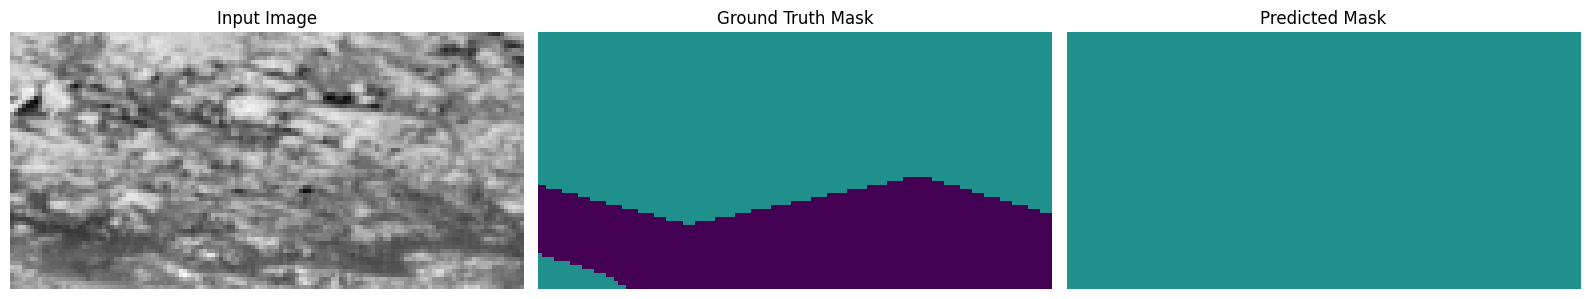

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 390ms/step - accuracy: 0.6944 - loss: 0.9755 - mean_iou: 0.6308 - val_accuracy: 0.6865 - val_loss: 0.9827 - val_mean_iou: 0.6236
Epoch 202/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 357ms/step - accuracy: 0.7029 - loss: 0.9689 - mean_iou: 0.6460 - val_accuracy: 0.6745 - val_loss: 0.9907 - val_mean_iou: 0.6043
Epoch 203/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.7003 - loss: 0.9682 - mean_iou: 0.6426 - val_accuracy: 0.6869 - val_loss: 0.9842 - val_mean_iou: 0.6241
Epoch 204/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accuracy: 0.7061 - loss: 0.9666 - mean_iou: 0.6473 - val_accuracy: 0.6779 - val_loss: 0.9947 - val_mean_iou: 0.6107
Epoch 205/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.6993 - loss: 0.9668 - mean_iou: 0.6586 - val_accuracy: 0.6653 - val_loss: 1.0069 - val_mean_iou: 0.5942
Epoch 206/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.6958 - loss: 0.9696 - mean_iou: 0.6439

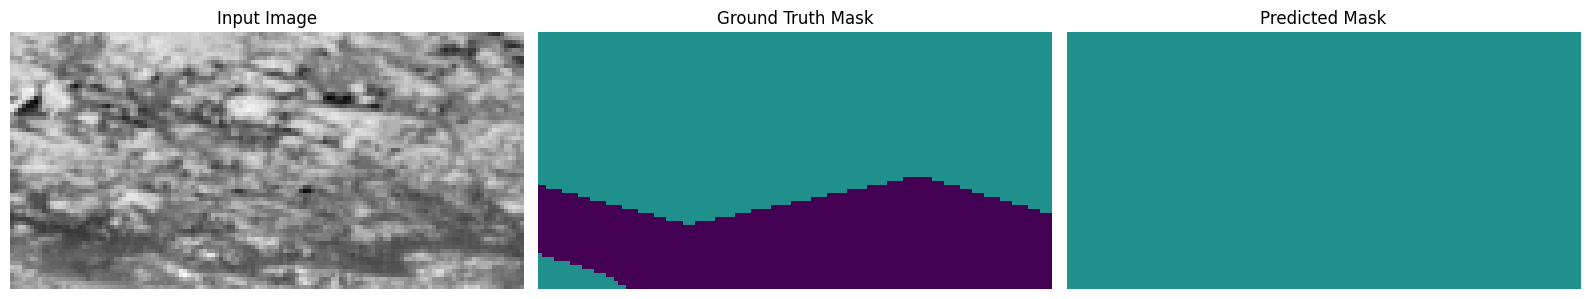

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 384ms/step - accuracy: 0.6959 - loss: 0.9695 - mean_iou: 0.6440 - val_accuracy: 0.6785 - val_loss: 0.9914 - val_mean_iou: 0.6095
Epoch 207/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.6999 - loss: 0.9697 - mean_iou: 0.6448 - val_accuracy: 0.6610 - val_loss: 1.0149 - val_mean_iou: 0.5782
Epoch 208/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.7074 - loss: 0.9664 - mean_iou: 0.6450 - val_accuracy: 0.6607 - val_loss: 1.0097 - val_mean_iou: 0.5794
Epoch 209/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7024 - loss: 0.9699 - mean_iou: 0.6396 - val_accuracy: 0.6850 - val_loss: 0.9819 - val_mean_iou: 0.6215
Epoch 210/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 366ms/step - accuracy: 0.7012 - loss: 0.9706 - mean_iou: 0.6409 - val_accuracy: 0.6818 - val_loss: 0.9865 - val_mean_iou: 0.6139
Epoch 211/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.7077 - loss: 0.9621 - mean_iou: 0.6552

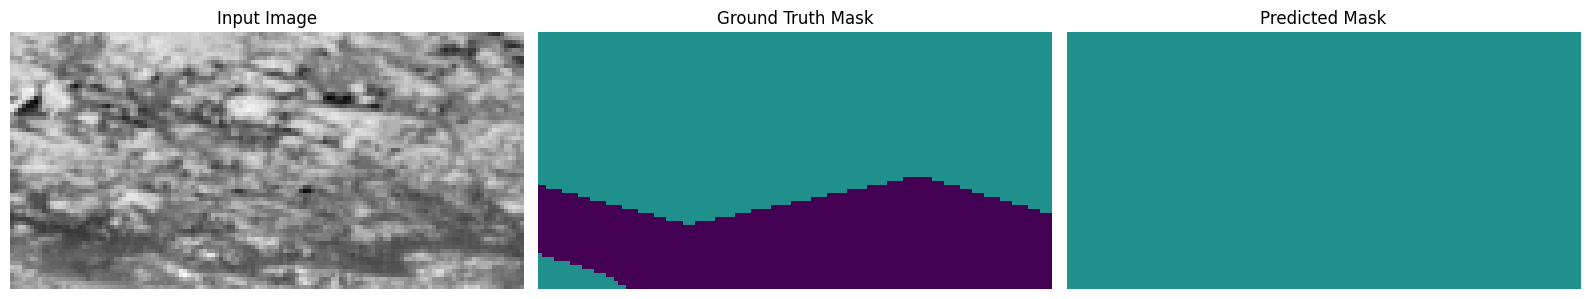

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 379ms/step - accuracy: 0.7075 - loss: 0.9621 - mean_iou: 0.6551 - val_accuracy: 0.6773 - val_loss: 0.9892 - val_mean_iou: 0.6066
Epoch 212/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.6990 - loss: 0.9732 - mean_iou: 0.6360 - val_accuracy: 0.6884 - val_loss: 0.9799 - val_mean_iou: 0.6273
Epoch 213/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7112 - loss: 0.9609 - mean_iou: 0.6575 - val_accuracy: 0.6893 - val_loss: 0.9773 - val_mean_iou: 0.6301
Epoch 214/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step - accuracy: 0.7028 - loss: 0.9668 - mean_iou: 0.6513 - val_accuracy: 0.6795 - val_loss: 0.9878 - val_mean_iou: 0.6106
Epoch 215/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.7016 - loss: 0.9677 - mean_iou: 0.6501 - val_accuracy: 0.6667 - val_loss: 0.9997 - val_mean_iou: 0.5918
Epoch 216/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.7093 - loss: 0.9669 - mean_iou: 0.6476

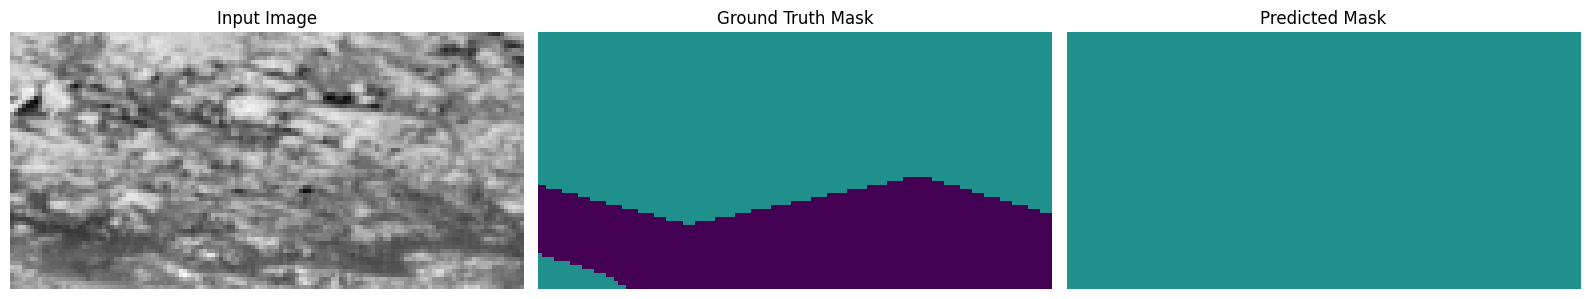

30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 392ms/step - accuracy: 0.7091 - loss: 0.9668 - mean_iou: 0.6477 - val_accuracy: 0.6795 - val_loss: 0.9937 - val_mean_iou: 0.6079
Epoch 217/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.7032 - loss: 0.9668 - mean_iou: 0.6475 - val_accuracy: 0.6670 - val_loss: 1.0022 - val_mean_iou: 0.5901
Epoch 218/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 362ms/step - accuracy: 0.6972 - loss: 0.9697 - mean_iou: 0.6427 - val_accuracy: 0.6750 - val_loss: 0.9887 - val_mean_iou: 0.6064
Epoch 219/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.7089 - loss: 0.9622 - mean_iou: 0.6543 - val_accuracy: 0.6666 - val_loss: 1.0049 - val_mean_iou: 0.5913
Epoch 220/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - accuracy: 0.6925 - loss: 0.9783 - mean_iou: 0.6291 - val_accuracy: 0.6598 - val_loss: 1.0070 - val_mean_iou: 0.5793
Epoch 221/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.7018 - loss: 0.9701 - mean_iou: 0.6451

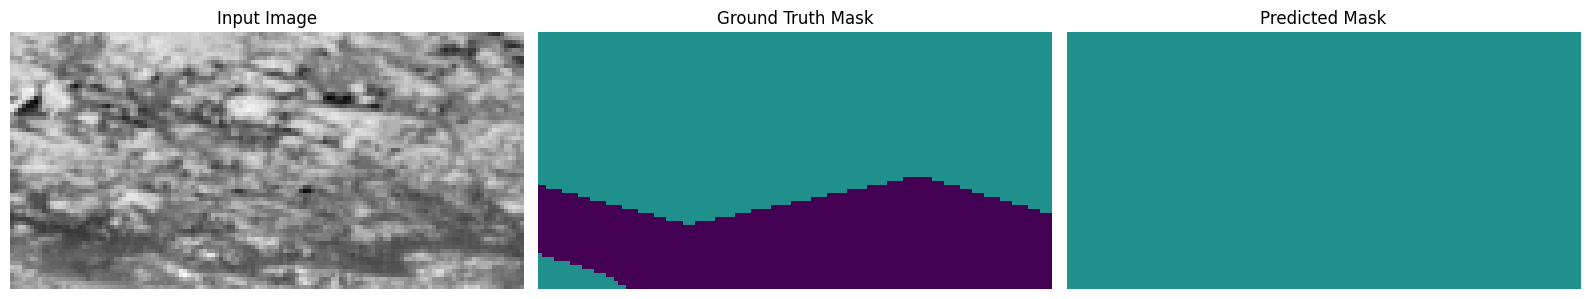

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.7017 - loss: 0.9701 - mean_iou: 0.6451 - val_accuracy: 0.6862 - val_loss: 0.9795 - val_mean_iou: 0.6236
Epoch 222/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.6912 - loss: 0.9754 - mean_iou: 0.6347 - val_accuracy: 0.6770 - val_loss: 0.9885 - val_mean_iou: 0.6101
Epoch 223/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 357ms/step - accuracy: 0.7005 - loss: 0.9678 - mean_iou: 0.6457 - val_accuracy: 0.6793 - val_loss: 0.9862 - val_mean_iou: 0.6137
Epoch 224/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.7174 - loss: 0.9555 - mean_iou: 0.6661 - val_accuracy: 0.6895 - val_loss: 0.9775 - val_mean_iou: 0.6306
Epoch 225/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.7073 - loss: 0.9645 - mean_iou: 0.6501 - val_accuracy: 0.6813 - val_loss: 0.9903 - val_mean_iou: 0.6169
Epoch 226/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.6971 - loss: 0.9716 - mean_iou: 0.6371

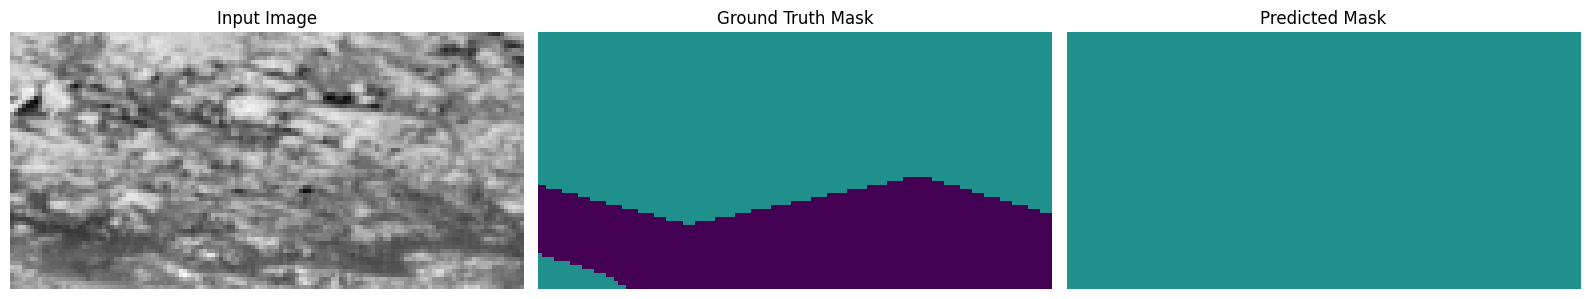

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.6972 - loss: 0.9714 - mean_iou: 0.6374 - val_accuracy: 0.6681 - val_loss: 1.0013 - val_mean_iou: 0.5878
Epoch 227/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 366ms/step - accuracy: 0.7050 - loss: 0.9650 - mean_iou: 0.6545 - val_accuracy: 0.6874 - val_loss: 0.9812 - val_mean_iou: 0.6261
Epoch 228/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.7138 - loss: 0.9625 - mean_iou: 0.6553 - val_accuracy: 0.6805 - val_loss: 0.9901 - val_mean_iou: 0.6137
Epoch 229/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 362ms/step - accuracy: 0.7024 - loss: 0.9686 - mean_iou: 0.6522 - val_accuracy: 0.6797 - val_loss: 0.9879 - val_mean_iou: 0.6149
Epoch 230/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - accuracy: 0.7067 - loss: 0.9670 - mean_iou: 0.6509 - val_accuracy: 0.6746 - val_loss: 0.9925 - val_mean_iou: 0.6032
Epoch 231/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.7082 - loss: 0.9639 - mean_iou: 0.6497

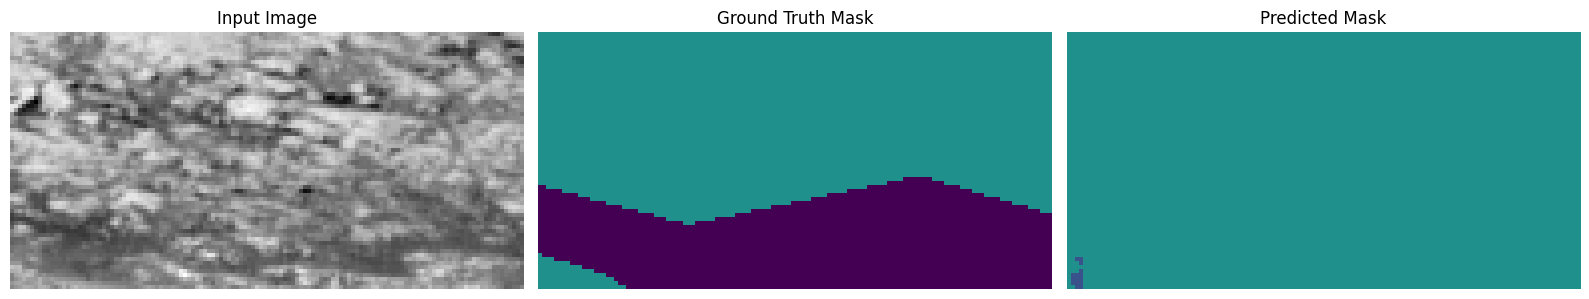

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.7082 - loss: 0.9638 - mean_iou: 0.6500 - val_accuracy: 0.6704 - val_loss: 0.9995 - val_mean_iou: 0.5939
Epoch 232/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.7041 - loss: 0.9660 - mean_iou: 0.6488 - val_accuracy: 0.6844 - val_loss: 0.9868 - val_mean_iou: 0.6200
Epoch 233/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.7053 - loss: 0.9660 - mean_iou: 0.6504 - val_accuracy: 0.6800 - val_loss: 0.9879 - val_mean_iou: 0.6136
Epoch 234/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 364ms/step - accuracy: 0.7010 - loss: 0.9712 - mean_iou: 0.6399 - val_accuracy: 0.6873 - val_loss: 0.9776 - val_mean_iou: 0.6260
Epoch 235/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 356ms/step - accuracy: 0.7071 - loss: 0.9624 - mean_iou: 0.6583 - val_accuracy: 0.6853 - val_loss: 0.9864 - val_mean_iou: 0.6236
Epoch 236/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.7061 - loss: 0.9612 - mean_iou: 0.6565

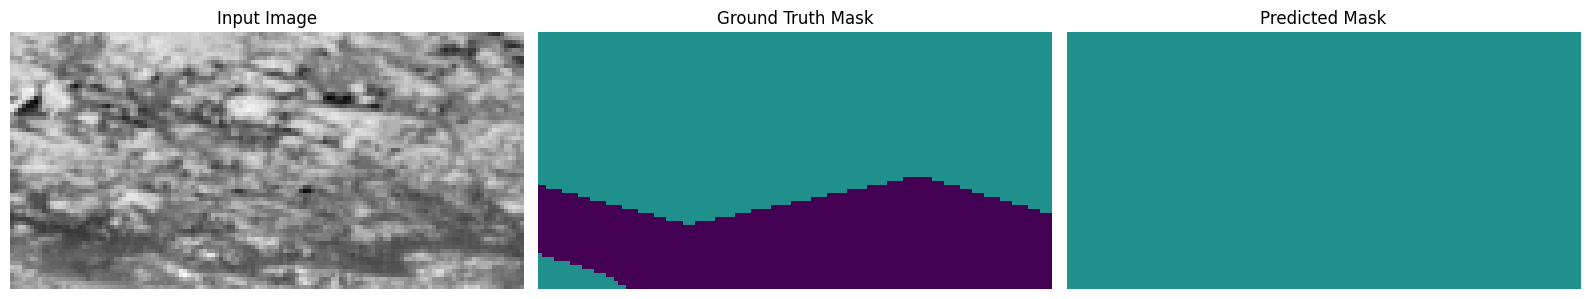

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - accuracy: 0.7062 - loss: 0.9610 - mean_iou: 0.6568 - val_accuracy: 0.6858 - val_loss: 0.9814 - val_mean_iou: 0.6258
Epoch 237/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step - accuracy: 0.7127 - loss: 0.9559 - mean_iou: 0.6643 - val_accuracy: 0.6826 - val_loss: 0.9848 - val_mean_iou: 0.6171
Epoch 238/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.7043 - loss: 0.9671 - mean_iou: 0.6639 - val_accuracy: 0.6796 - val_loss: 0.9907 - val_mean_iou: 0.6145
Epoch 239/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 355ms/step - accuracy: 0.7080 - loss: 0.9621 - mean_iou: 0.6545 - val_accuracy: 0.6816 - val_loss: 0.9867 - val_mean_iou: 0.6145
Epoch 240/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step - accuracy: 0.7024 - loss: 0.9625 - mean_iou: 0.6506 - val_accuracy: 0.6807 - val_loss: 0.9878 - val_mean_iou: 0.6133
Epoch 241/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.7044 - loss: 0.9640 - mean_iou: 0.6488

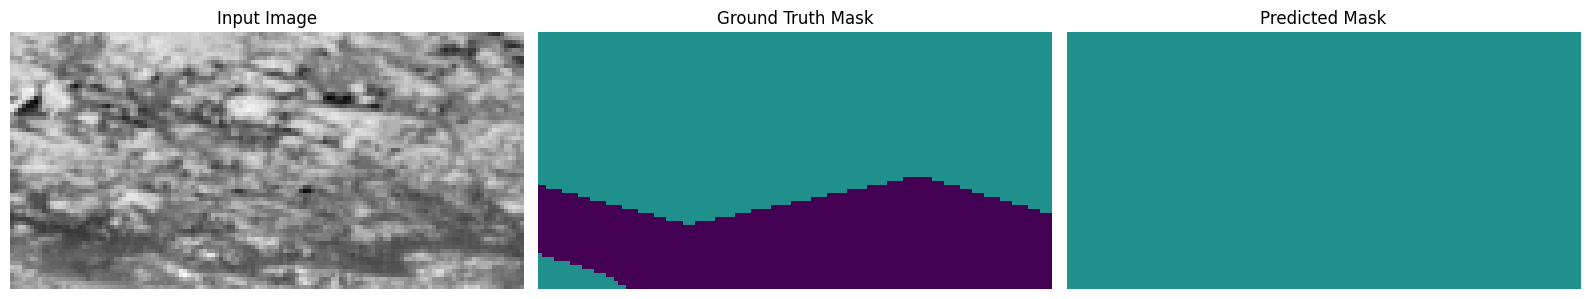

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.7045 - loss: 0.9638 - mean_iou: 0.6492 - val_accuracy: 0.6773 - val_loss: 0.9905 - val_mean_iou: 0.6075
Epoch 242/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.7130 - loss: 0.9568 - mean_iou: 0.6655 - val_accuracy: 0.6869 - val_loss: 0.9813 - val_mean_iou: 0.6245
Epoch 243/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 355ms/step - accuracy: 0.6998 - loss: 0.9679 - mean_iou: 0.6486 - val_accuracy: 0.6854 - val_loss: 0.9836 - val_mean_iou: 0.6210
Epoch 244/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.7122 - loss: 0.9579 - mean_iou: 0.6635 - val_accuracy: 0.6707 - val_loss: 0.9971 - val_mean_iou: 0.5985
Epoch 245/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - accuracy: 0.7162 - loss: 0.9531 - mean_iou: 0.6691 - val_accuracy: 0.6681 - val_loss: 1.0044 - val_mean_iou: 0.5942
Epoch 246/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7061 - loss: 0.9629 - mean_iou: 0.6529

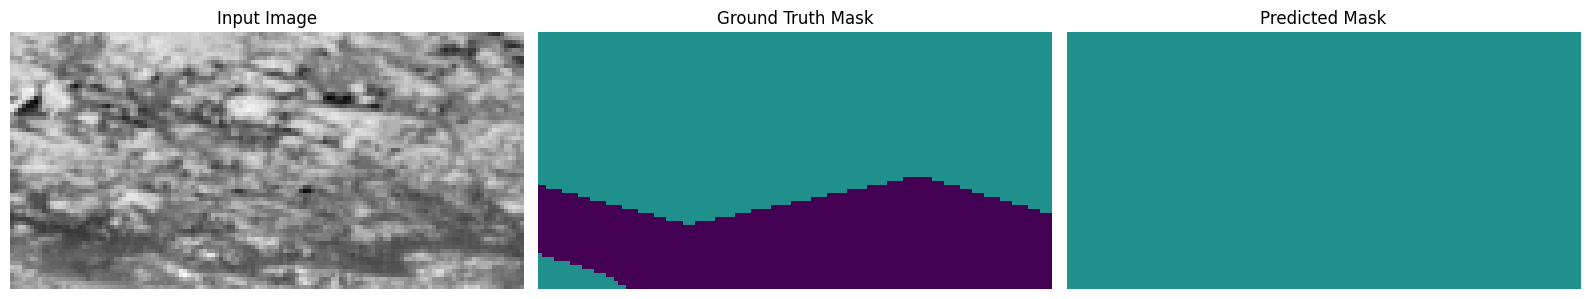

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 365ms/step - accuracy: 0.7062 - loss: 0.9628 - mean_iou: 0.6530 - val_accuracy: 0.6809 - val_loss: 0.9861 - val_mean_iou: 0.6156
Epoch 247/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.7058 - loss: 0.9640 - mean_iou: 0.6496 - val_accuracy: 0.6842 - val_loss: 0.9832 - val_mean_iou: 0.6212
Epoch 248/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.7114 - loss: 0.9558 - mean_iou: 0.6638 - val_accuracy: 0.6904 - val_loss: 0.9794 - val_mean_iou: 0.6298
Epoch 249/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 365ms/step - accuracy: 0.7126 - loss: 0.9569 - mean_iou: 0.6623 - val_accuracy: 0.6782 - val_loss: 0.9948 - val_mean_iou: 0.6085
Epoch 250/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 356ms/step - accuracy: 0.7061 - loss: 0.9639 - mean_iou: 0.6569 - val_accuracy: 0.6843 - val_loss: 0.9828 - val_mean_iou: 0.6208
Epoch 251/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.7033 - loss: 0.9643 - mean_iou: 0.6518

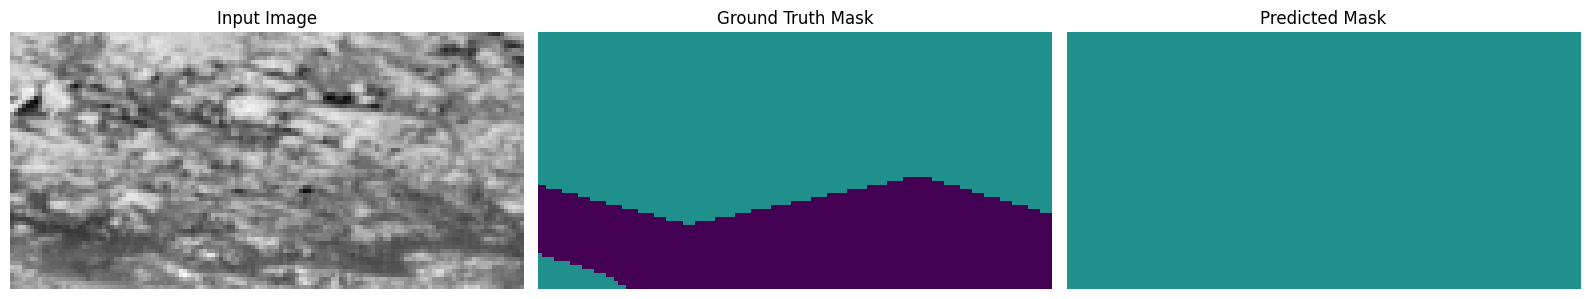

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.7034 - loss: 0.9642 - mean_iou: 0.6520 - val_accuracy: 0.6858 - val_loss: 0.9826 - val_mean_iou: 0.6232
Epoch 252/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 350ms/step - accuracy: 0.7059 - loss: 0.9628 - mean_iou: 0.6546 - val_accuracy: 0.6875 - val_loss: 0.9820 - val_mean_iou: 0.6258
Epoch 253/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 353ms/step - accuracy: 0.7070 - loss: 0.9600 - mean_iou: 0.6578 - val_accuracy: 0.6837 - val_loss: 0.9805 - val_mean_iou: 0.6192
Epoch 254/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.7150 - loss: 0.9578 - mean_iou: 0.6613 - val_accuracy: 0.6809 - val_loss: 0.9886 - val_mean_iou: 0.6160
Epoch 255/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - accuracy: 0.7132 - loss: 0.9552 - mean_iou: 0.6674 - val_accuracy: 0.6824 - val_loss: 0.9863 - val_mean_iou: 0.6183
Epoch 256/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.7054 - loss: 0.9635 - mean_iou: 0.6531

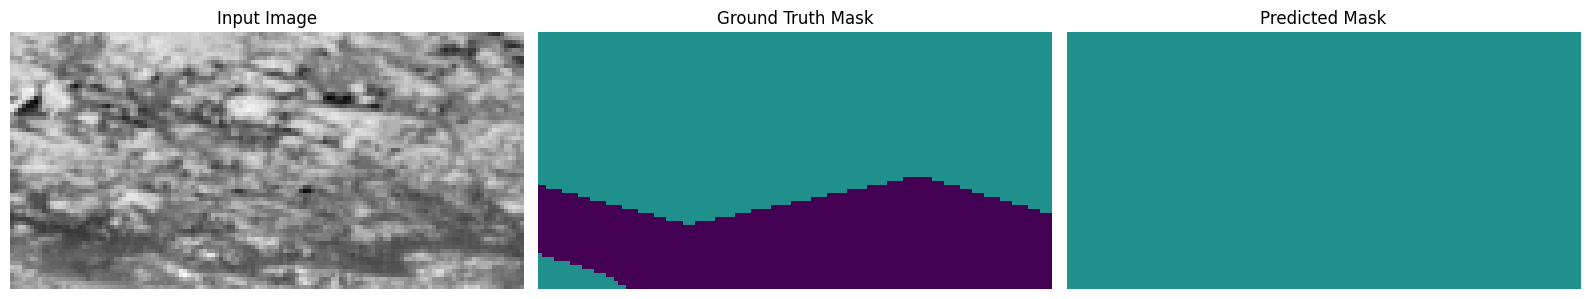

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.7055 - loss: 0.9633 - mean_iou: 0.6534 - val_accuracy: 0.6787 - val_loss: 0.9879 - val_mean_iou: 0.6082
Epoch 257/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 351ms/step - accuracy: 0.7146 - loss: 0.9544 - mean_iou: 0.6668 - val_accuracy: 0.6836 - val_loss: 0.9807 - val_mean_iou: 0.6178
Epoch 258/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 363ms/step - accuracy: 0.7004 - loss: 0.9664 - mean_iou: 0.6467 - val_accuracy: 0.6776 - val_loss: 0.9854 - val_mean_iou: 0.6083
Epoch 259/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.7104 - loss: 0.9585 - mean_iou: 0.6627 - val_accuracy: 0.6792 - val_loss: 0.9853 - val_mean_iou: 0.6115
Epoch 260/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 347ms/step - accuracy: 0.7155 - loss: 0.9586 - mean_iou: 0.6631 - val_accuracy: 0.6859 - val_loss: 0.9792 - val_mean_iou: 0.6236
Epoch 261/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.7198 - loss: 0.9510 - mean_iou: 0.6733

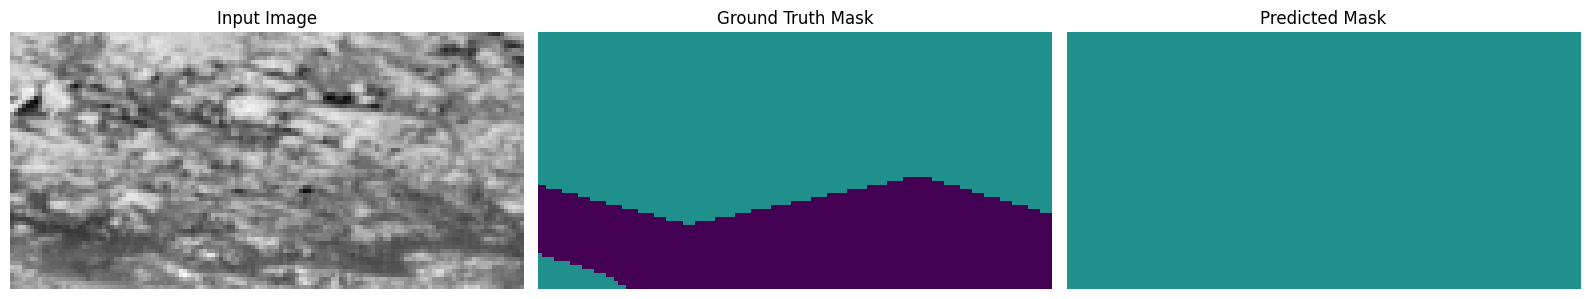

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accuracy: 0.7197 - loss: 0.9510 - mean_iou: 0.6733 - val_accuracy: 0.6848 - val_loss: 0.9791 - val_mean_iou: 0.6218
Epoch 262/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 343ms/step - accuracy: 0.7062 - loss: 0.9590 - mean_iou: 0.6564 - val_accuracy: 0.6841 - val_loss: 0.9820 - val_mean_iou: 0.6186
Epoch 263/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - accuracy: 0.7049 - loss: 0.9649 - mean_iou: 0.6509 - val_accuracy: 0.6826 - val_loss: 0.9837 - val_mean_iou: 0.6188
Epoch 264/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 351ms/step - accuracy: 0.7139 - loss: 0.9554 - mean_iou: 0.6665 - val_accuracy: 0.6763 - val_loss: 0.9835 - val_mean_iou: 0.6060
Epoch 265/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - accuracy: 0.7093 - loss: 0.9610 - mean_iou: 0.6562 - val_accuracy: 0.6786 - val_loss: 0.9892 - val_mean_iou: 0.6081
Epoch 266/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7130 - loss: 0.9545 - mean_iou: 0.6722

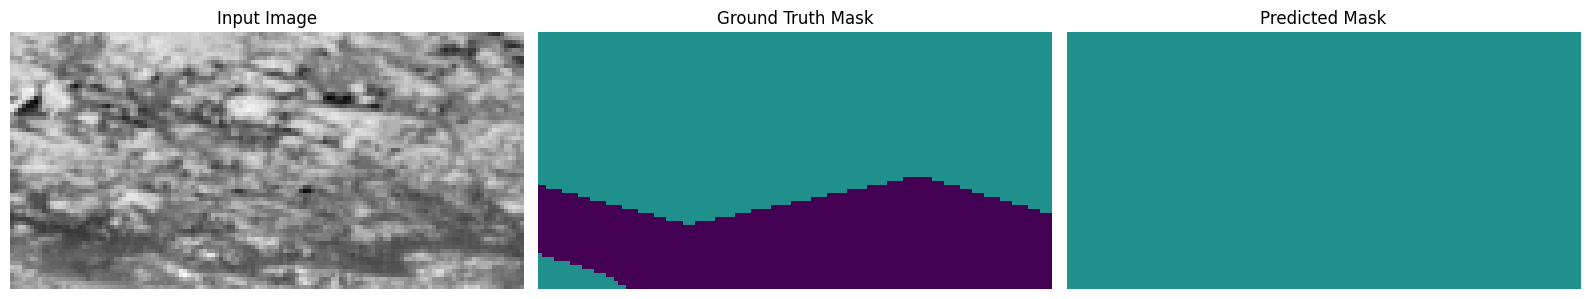

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 364ms/step - accuracy: 0.7129 - loss: 0.9545 - mean_iou: 0.6720 - val_accuracy: 0.6874 - val_loss: 0.9777 - val_mean_iou: 0.6261
Epoch 267/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.7164 - loss: 0.9590 - mean_iou: 0.6632 - val_accuracy: 0.6728 - val_loss: 0.9983 - val_mean_iou: 0.6018
Epoch 268/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.7132 - loss: 0.9584 - mean_iou: 0.6610 - val_accuracy: 0.6691 - val_loss: 0.9967 - val_mean_iou: 0.5977
Epoch 269/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.7047 - loss: 0.9636 - mean_iou: 0.6548 - val_accuracy: 0.6646 - val_loss: 1.0024 - val_mean_iou: 0.5859
Epoch 270/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step - accuracy: 0.7121 - loss: 0.9572 - mean_iou: 0.6617 - val_accuracy: 0.6764 - val_loss: 0.9932 - val_mean_iou: 0.6085
Epoch 271/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.7032 - loss: 0.9606 - mean_iou: 0.6508

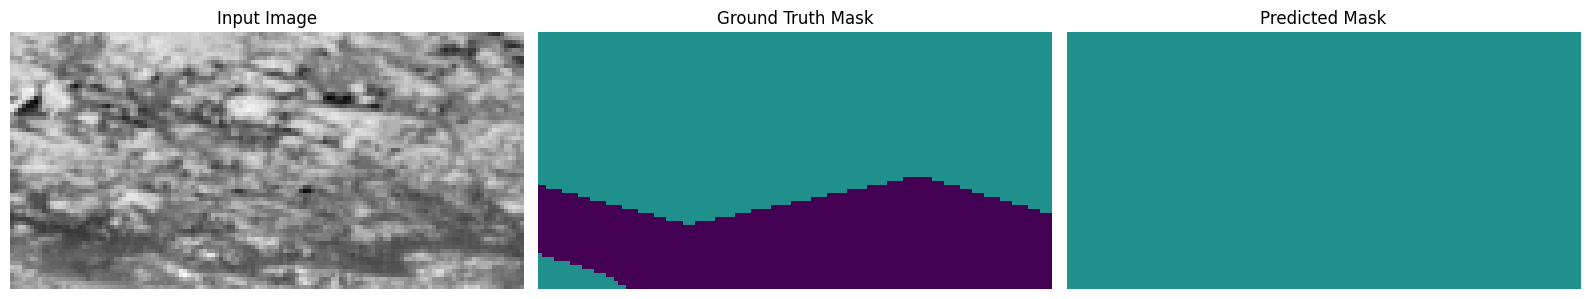

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.7032 - loss: 0.9606 - mean_iou: 0.6509 - val_accuracy: 0.6869 - val_loss: 0.9798 - val_mean_iou: 0.6246
Epoch 272/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 366ms/step - accuracy: 0.7181 - loss: 0.9512 - mean_iou: 0.6724 - val_accuracy: 0.6882 - val_loss: 0.9770 - val_mean_iou: 0.6277
Epoch 273/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.7071 - loss: 0.9603 - mean_iou: 0.6577 - val_accuracy: 0.6783 - val_loss: 0.9910 - val_mean_iou: 0.6114
Epoch 274/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.7040 - loss: 0.9619 - mean_iou: 0.6546 - val_accuracy: 0.6850 - val_loss: 0.9880 - val_mean_iou: 0.6204
Final validation Mean Intersection Over Union: 63.06%


In [22]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    batch_size=BATCH_SIZE,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'model_UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
# del model

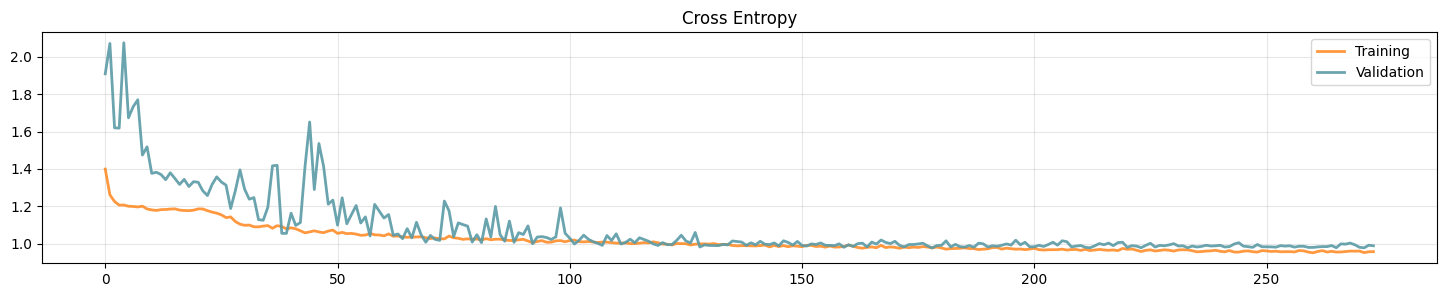

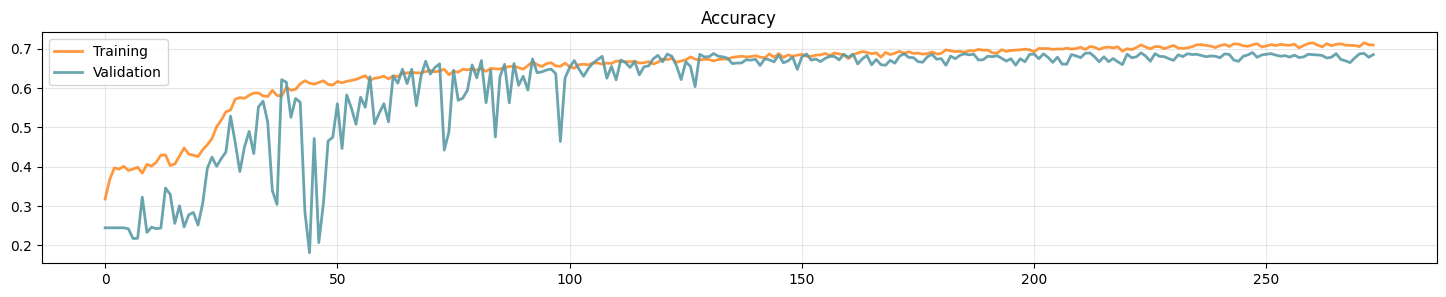

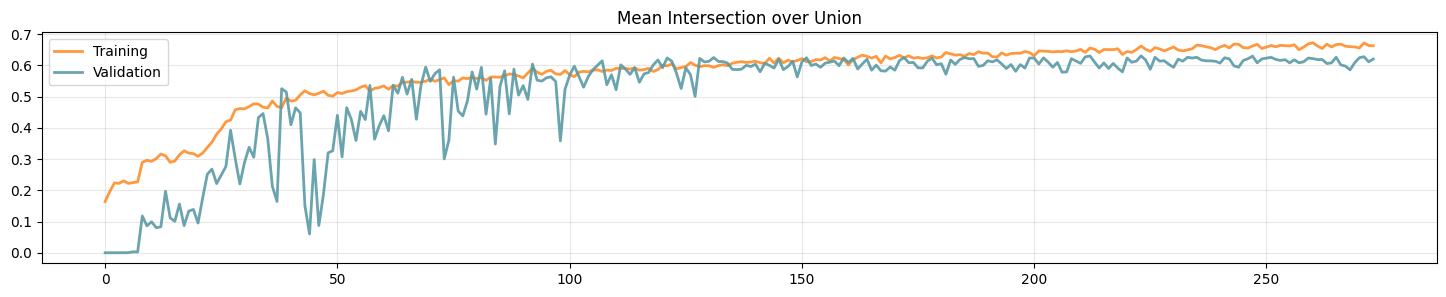

In [23]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [24]:
# If model_filename is not defined, load the most recent model from Google Drive
# if "model_filename" not in globals() or model_filename is None:
#     files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
#     files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
#     if files:
#         model_filename = files[0]
#     else:
#         raise FileNotFoundError("No model files found in the current directory.")

In [25]:
# model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model_UNet_63.06.keras


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
(300, 64, 128, 5)
Predictions shape: (300, 64, 128)


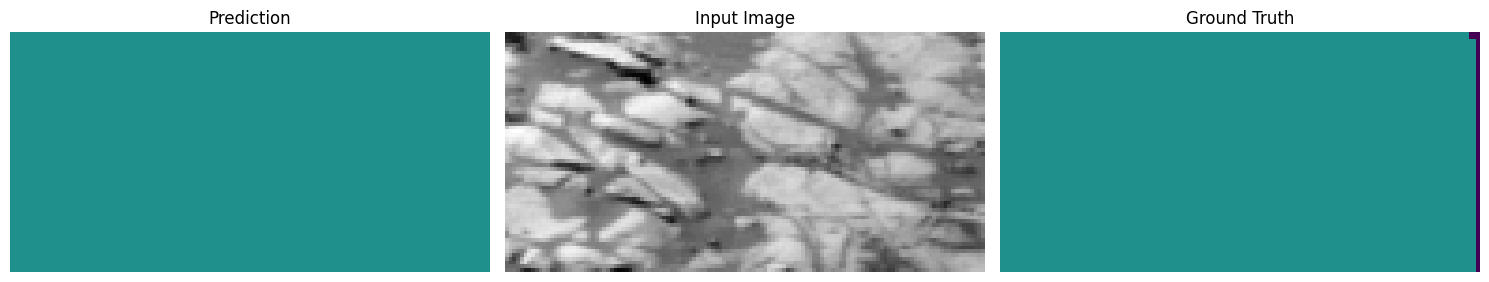

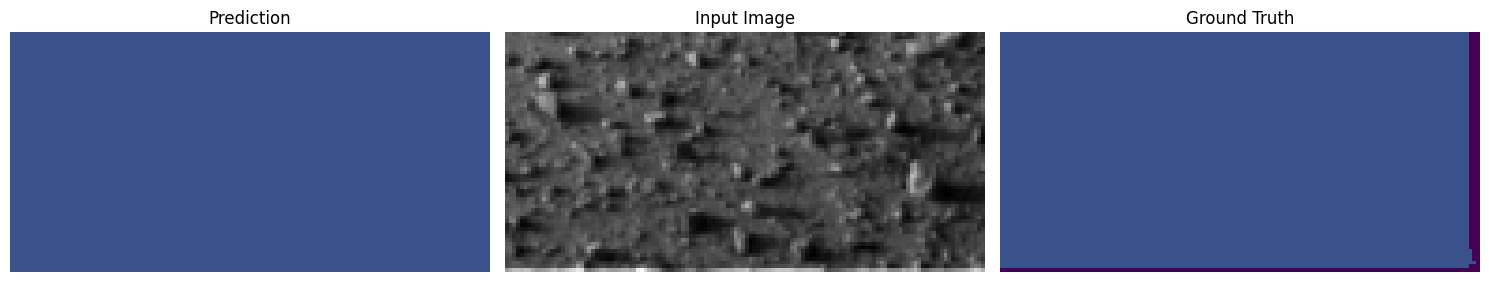

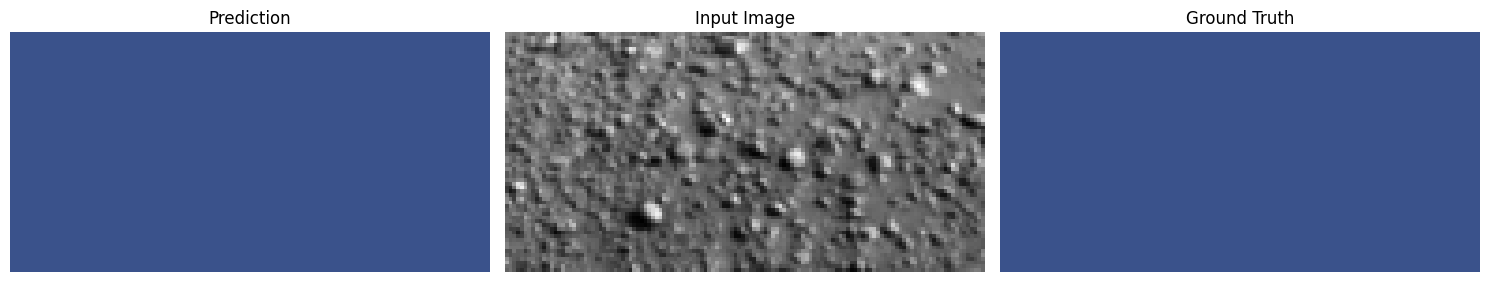

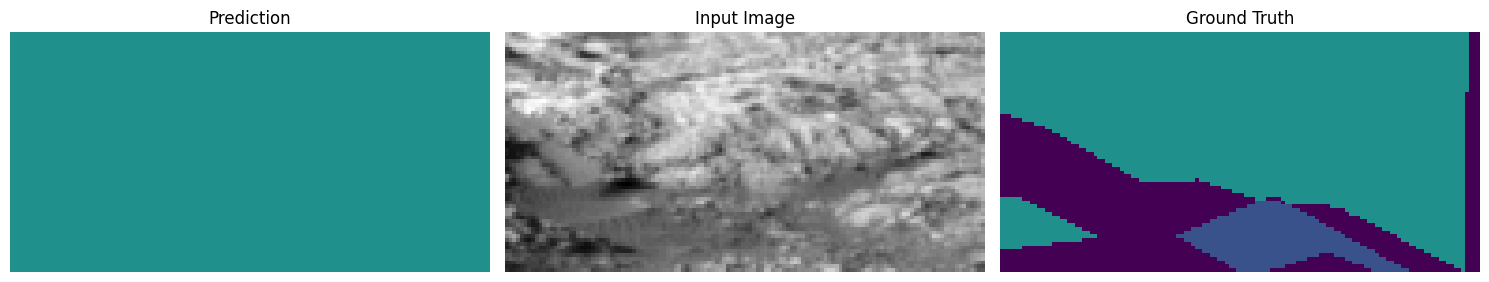

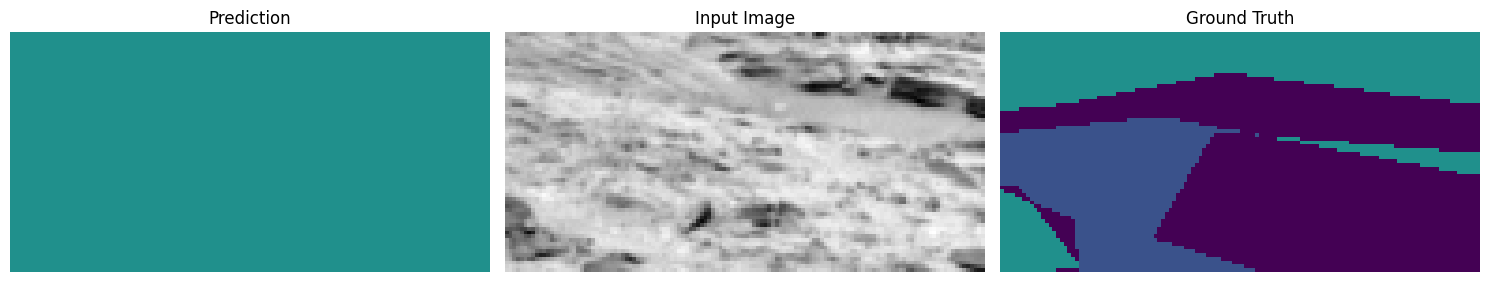

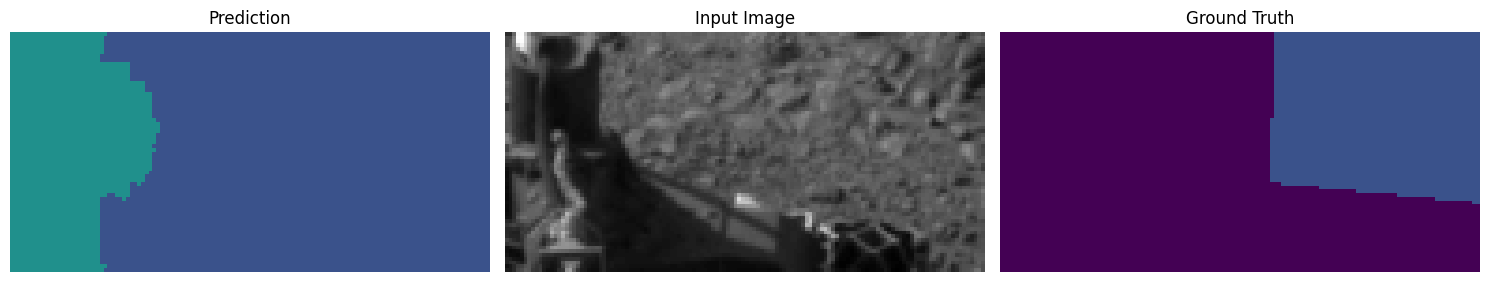

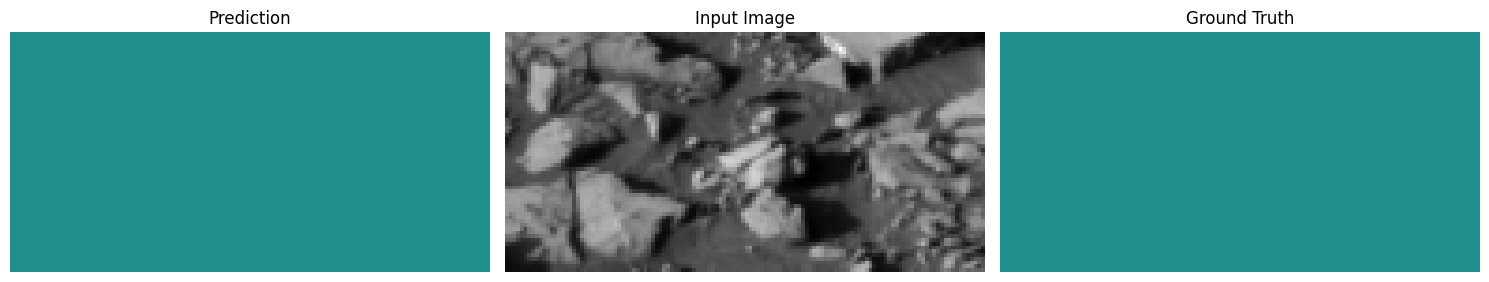

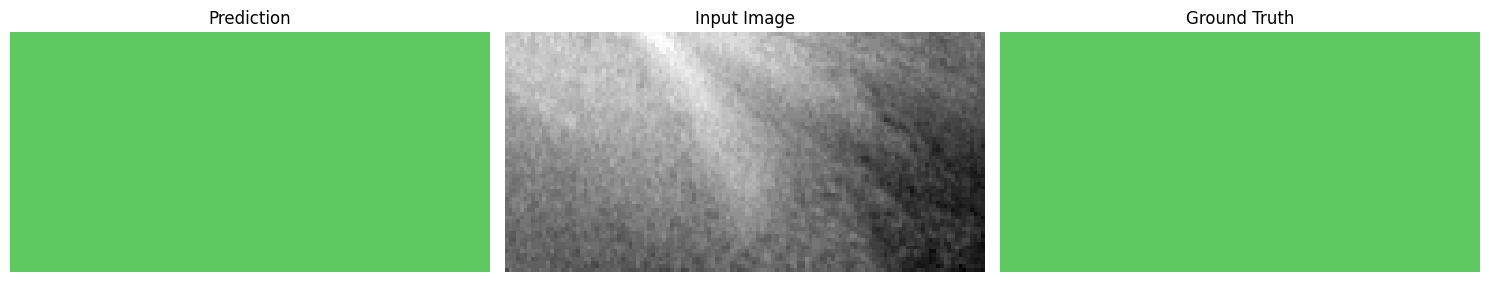

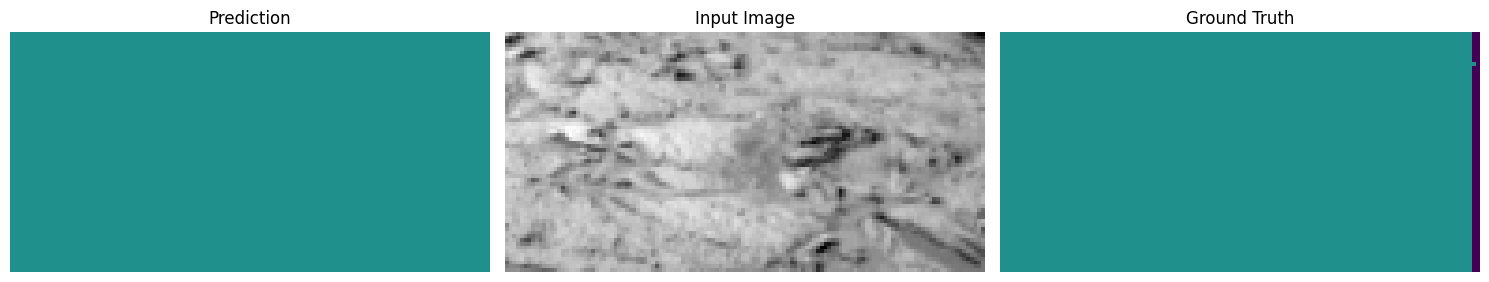

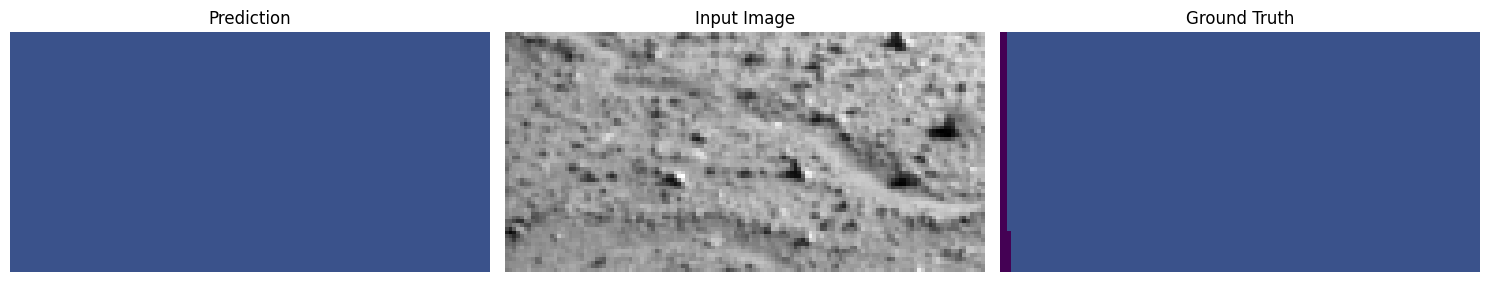

In [37]:
preds = model.predict(test_dataset)
predicted_classes = np.argmax(preds, axis=-1)
print(preds.shape)
preds[predicted_classes == 0] = -1  # Ensure preds and predicted_classes have compatible shapes
preds = np.argmax(preds, axis=-1)
#print(test_lbl[0])
print(f"Predictions shape: {preds.shape}")
#accuracy
#show predictions ....
colormap = create_segmentation_colormap(num_classes)
for i in range(10):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 3 subplots

  colored_label = apply_colormap(preds[i], colormap)
  colored_truth = apply_colormap(test_lbl[i], colormap)

  # Prediction
  axes[0].imshow(colored_label)
  axes[0].set_title("Prediction")
  axes[0].axis('off')  # Turn off axis labels

  # Input image
  axes[1].imshow(test_img[i], cmap='gray')
  axes[1].set_title("Input Image")
  axes[1].axis('off')

  # Ground truth label
  axes[2].imshow(colored_truth)
  axes[2].set_title("Ground Truth")
  axes[2].axis('off')

  plt.tight_layout()  # Adjust subplot parameters for a tight layout
  plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


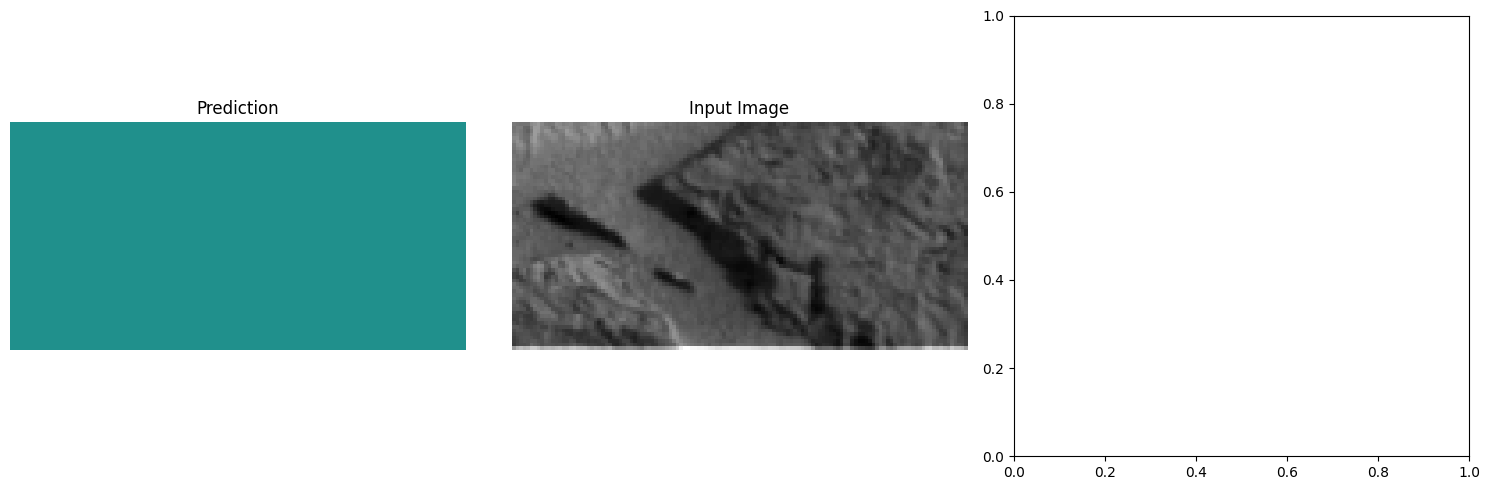

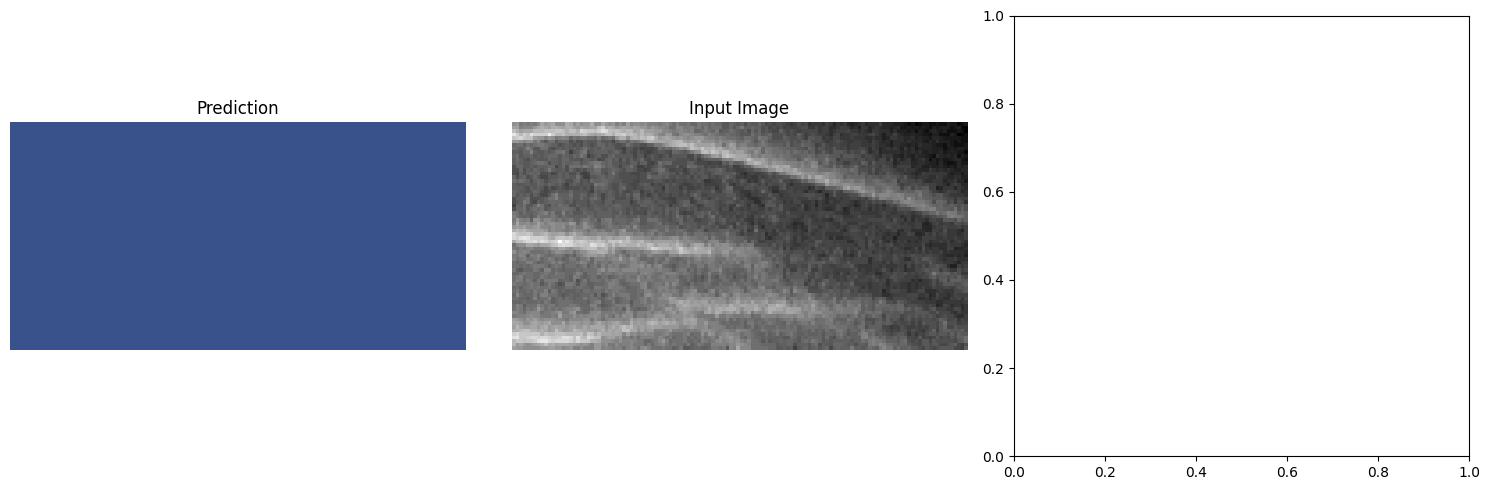

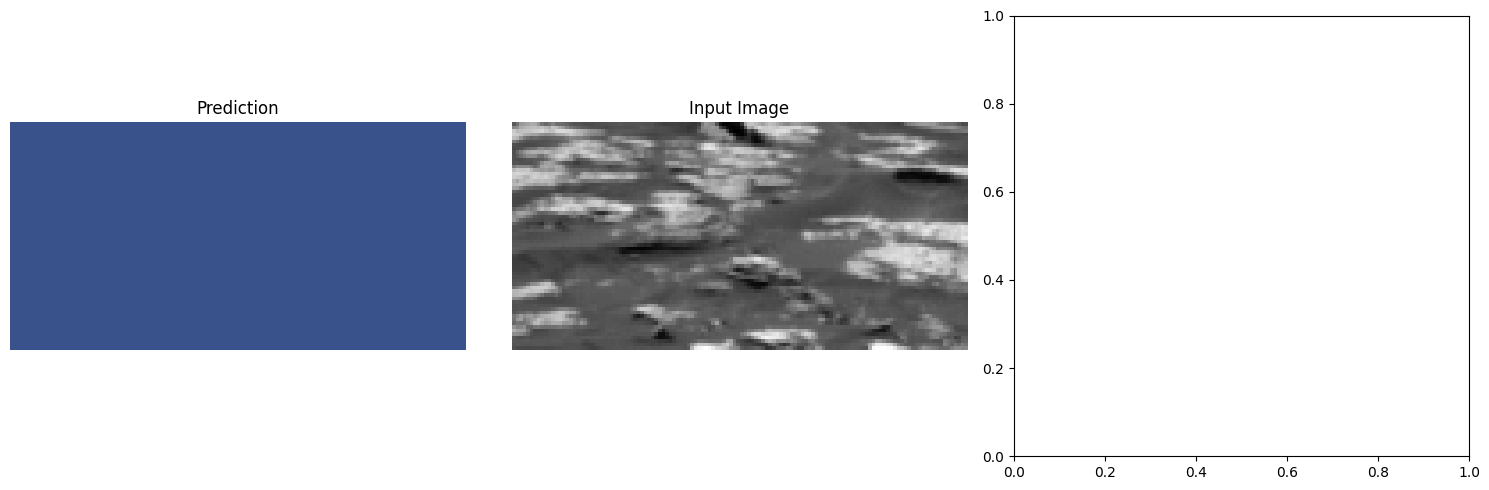

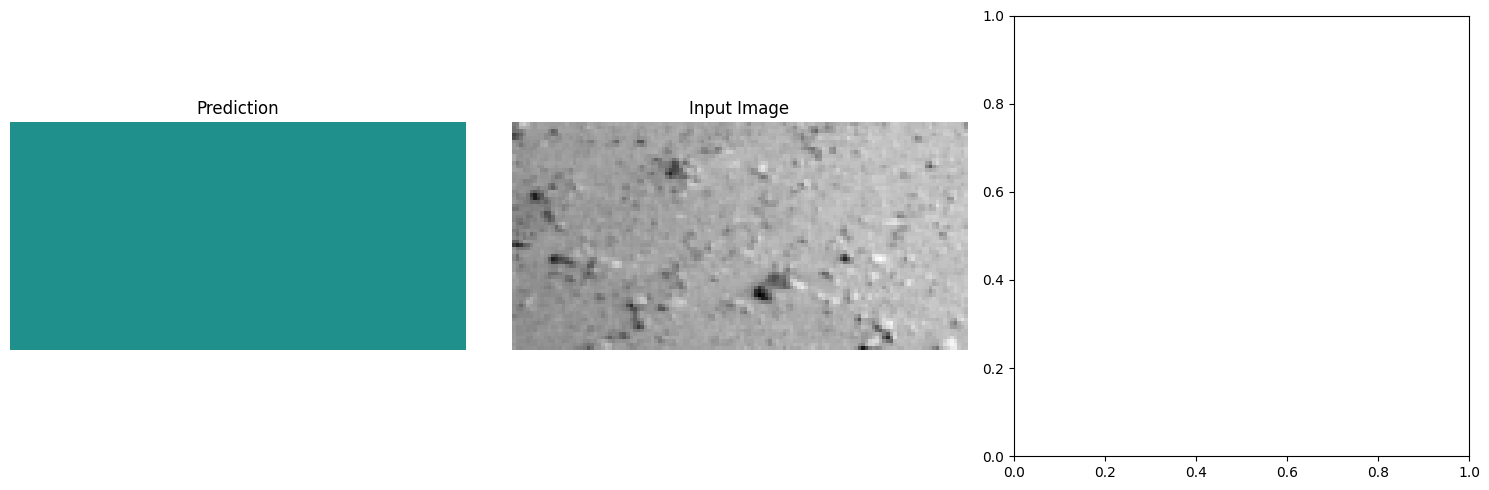

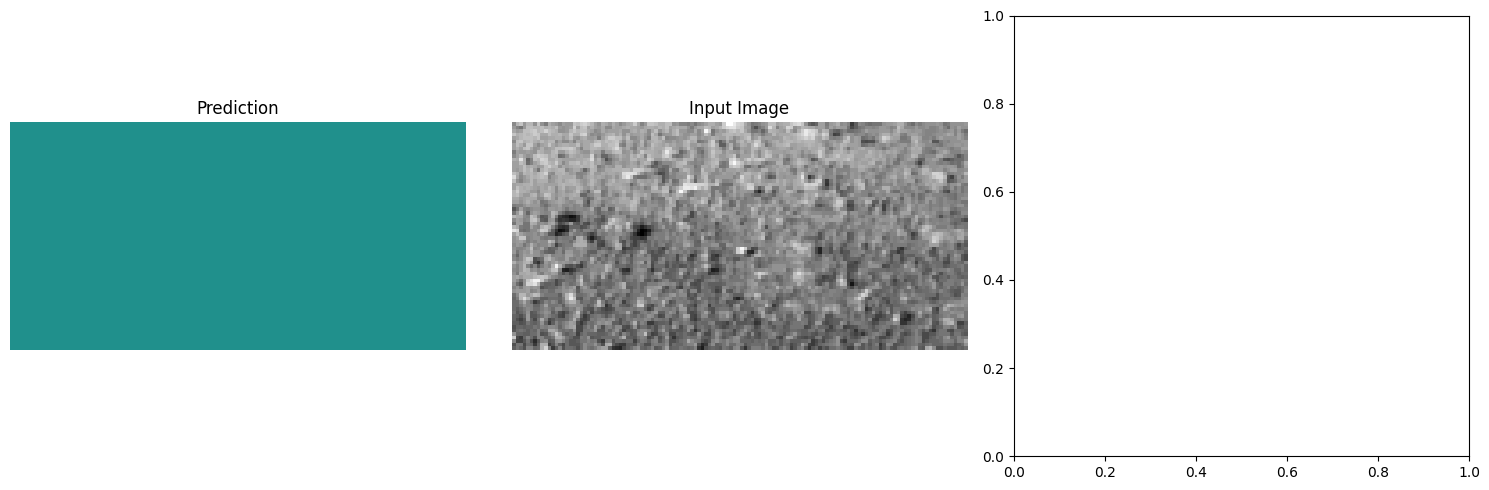

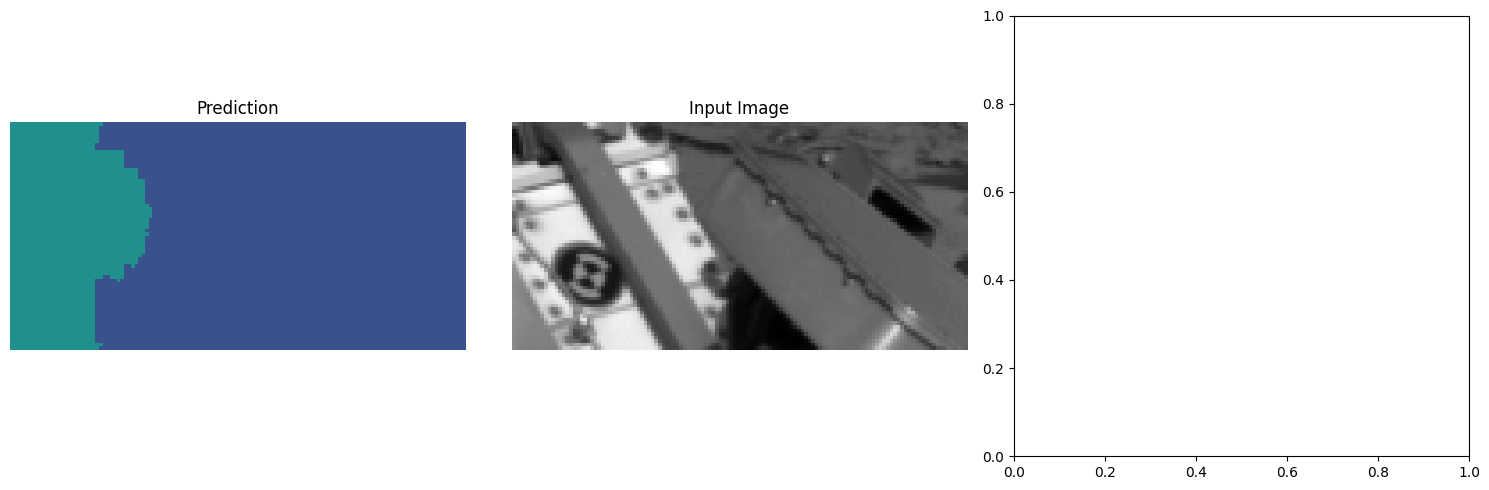

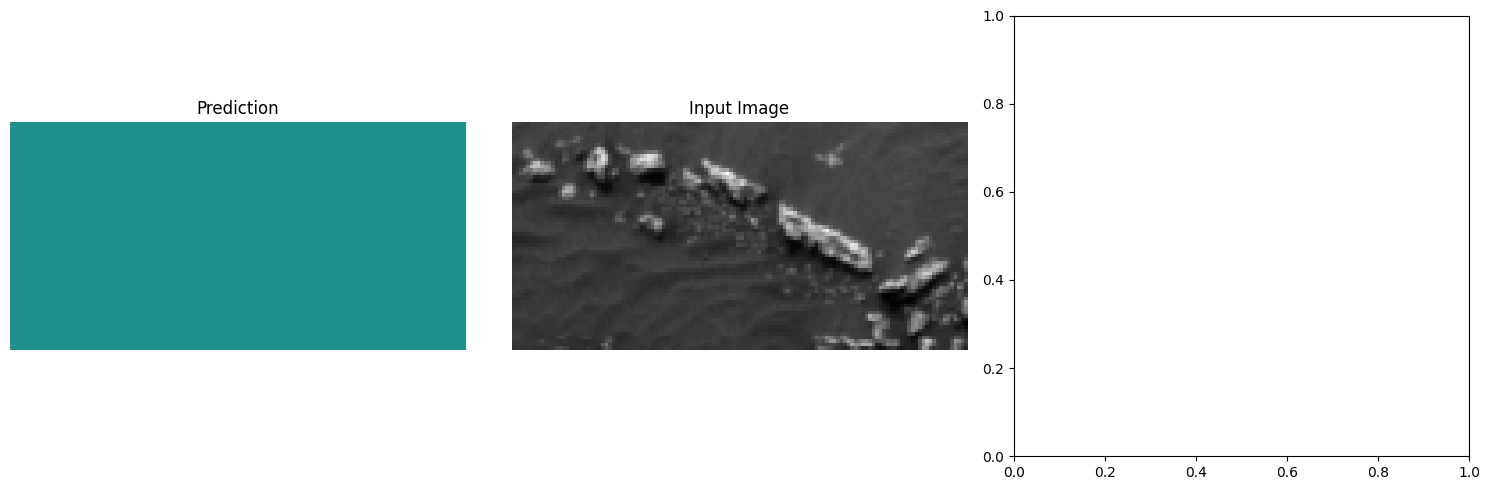

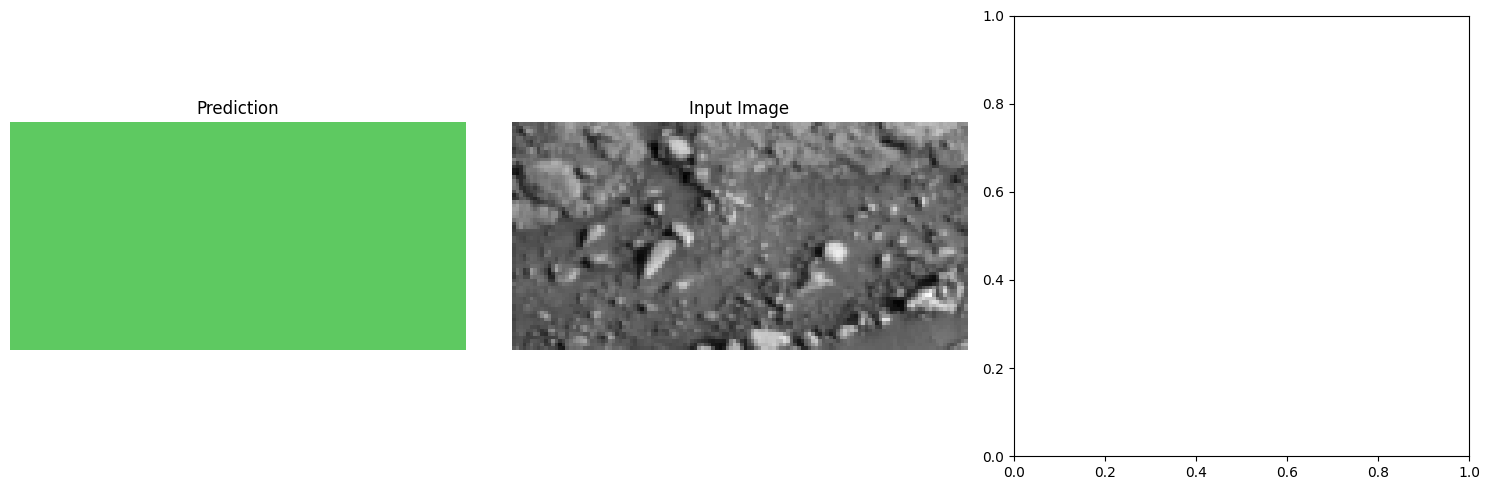

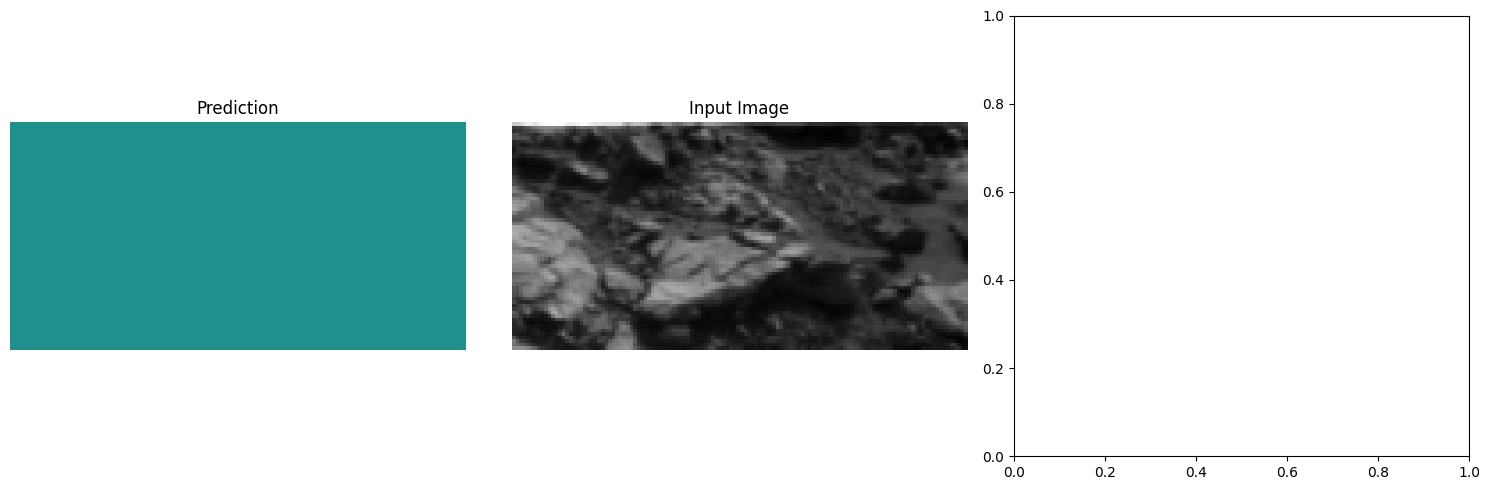

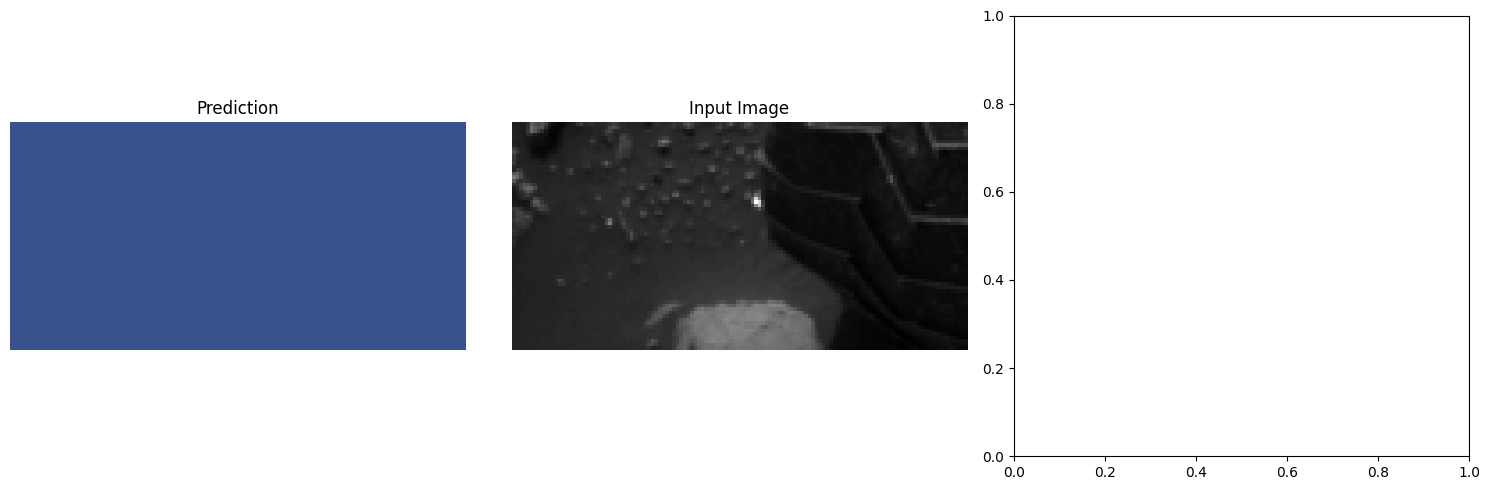

In [39]:
preds = model.predict(test_dataset)
predicted_classes = np.argmax(preds, axis=-1)
preds[predicted_classes == 0] = -1  # Ensure preds and predicted_classes have compatible shapes
preds = np.argmax(preds, axis=-1)

for i in range(10):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 3 subplots

  colored_label = apply_colormap(preds[i], colormap)

  # Prediction
  axes[0].imshow(colored_label)
  axes[0].set_title("Prediction")
  axes[0].axis('off')  # Turn off axis labels

  # Input image
  axes[1].imshow(X_test[i], cmap='gray')
  axes[1].set_title("Input Image")
  axes[1].axis('off')

  plt.tight_layout()  # Adjust subplot parameters for a tight layout
  plt.show()


In [40]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [41]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)
print(submission_filename)
from google.colab import files
files.download(submission_filename)

submission_UNet_63.06.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# disconnect
from google.colab import runtime
runtime.unassign()


#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```